# Predict the genetic disorders
##### Probelm statement
Predic the the following
1. Genetic Disorder
2. Disorder subclass

##### Overall Approach
- Used ML random forest techniques to impute the missing values for both categorical and numerical
- Original training data had size of 22083 x 45, but after treating missing values from both the target variable the data size became 21805 
- Sampled data was run against RandomForest, XGBoost, H2o, Lightgbm and pyCaret which were giving final leaderboard F1 scores in the range of 32.5 to 34.35
- Hyper parameter tuning of the above models helped to increased the F1 score to 34.35 to 36.48
- Also tried some feature engineering techniques to reduce the features, And Prepared a balanced training dataset using oversampling SMOTE for minority classes and ran all the ML models

**Method 1:**

Built model for target variable Genetic Disorder excluding the second the target variable. 

**Method 2:**

Built model for target variable Disorder subclass excluding the Genetic Disorder as independent variable. 

Finally combined method 1 scores and method 2 scores for the submissions

##### Preprocessing and Feature Engineering:
- Most pre-processing steps (encoding, normalization/standardization, etc) was done before under/over-sampling the data.

- One hot encoding done for categorical features.

- Continous features preprocessing using standard scalar with mean = False for Random Forest, Xgboost and LightGBM 

- Correlated features were removed before training

- The details of preprocessing and feature engineering is given in the respective coding sections

##### Training Methodology:
- For Multi classifiers models built using Random Forest, Xgboost and Light gbm we used Startified K fold sampling with 5 folds to avoid over fitting

- Further improved the model performance using hyper parameter tuning with the help of fmin function in hyperopt opensource library

- Also trained the model using automated ML library H2O and pycaret

Details provided in coding section.

### Settings and Import Datasets

In [15]:
## Import basic libraries
import pandas as pd
import numpy as np
import os
## Data location
path = '/hackerarth_prediction/dataset'
os.chdir(path)
## Display settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')
from collections import Counter

# Visualisation python lib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Load train and test data

In [2]:
df_train = pd.read_csv("train.csv")
df_train.shape

(22083, 45)

In [3]:
df_test = pd.read_csv("test.csv")
df_test.shape

(9465, 43)

In [4]:
## Checking what is extra column there in train and test
set(df_train.columns)-set(df_test.columns)

{'Disorder Subclass', 'Genetic Disorder'}

In [5]:
## Add two columns which are not available on test
df_test['Disorder Subclass'] = np.nan
df_test['Genetic Disorder'] = np.nan

##### Clean the column names

In [6]:
### Function to clean the column name
def clean_col_name (cname):
    pat_value = [' ', '(', ')','/','\'','-']
    repl_value = ['_', '', '','','','']
    for j in range(len(repl_value)):
        cname = [x.replace(pat_value[j], repl_value[j]) for x in cname]
    cname = [x.lower() for x in cname]
    return(cname)

In [7]:
df_train.columns = clean_col_name(df_train.columns)
df_test.columns = clean_col_name(df_test.columns)

In [8]:
### Lets combine train and test data before data preprocessing
df_train['myflag'] = 'train'
df_test['myflag'] = 'test'
df_master = pd.concat([df_train,df_test], axis=0).reset_index(drop=True)
df_master.shape

(31548, 46)

In [9]:
df_master.columns

Index(['patient_id', 'patient_age', 'genes_in_mothers_side',
       'inherited_from_father', 'maternal_gene', 'paternal_gene',
       'blood_cell_count_mcl', 'patient_first_name', 'family_name',
       'fathers_name', 'mothers_age', 'fathers_age', 'institute_name',
       'location_of_institute', 'status', 'respiratory_rate_breathsmin',
       'heart_rate_ratesmin', 'test_1', 'test_2', 'test_3', 'test_4', 'test_5',
       'parental_consent', 'followup', 'gender', 'birth_asphyxia',
       'autopsy_shows_birth_defect_if_applicable', 'place_of_birth',
       'folic_acid_details_periconceptional', 'ho_serious_maternal_illness',
       'ho_radiation_exposure_xray', 'ho_substance_abuse',
       'assisted_conception_ivfart',
       'history_of_anomalies_in_previous_pregnancies',
       'no._of_previous_abortion', 'birth_defects',
       'white_blood_cell_count_thousand_per_microliter', 'blood_test_result',
       'symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5',
       'genetic

In [ ]:
df_master.to_csv("df_master.csv", index=False)

### Data Pre - processing

In [10]:
df_master.myflag.value_counts()

train    22083
test      9465
Name: myflag, dtype: int64

#### 1. Explore target variable

In [11]:
## From the problem statement it is clear that we have to predict both Genitic disorder and Disorder sublcass
## let us understand target variable fist
mytarget = df_master[df_master['myflag']=='train'][['patient_id','genetic_disorder', 'disorder_subclass']]
print(mytarget.shape)

(22083, 3)


In [12]:
## there are some missing in target and replacing them by name missing
mytarget.fillna("missing", inplace=True)

In [13]:
mytarget.groupby(['genetic_disorder']).patient_id.nunique()

genetic_disorder
Mitochondrial genetic inheritance disorders     10202
Multifactorial genetic inheritance disorders     2071
Single-gene inheritance diseases                 7664
missing                                          2146
Name: patient_id, dtype: int64

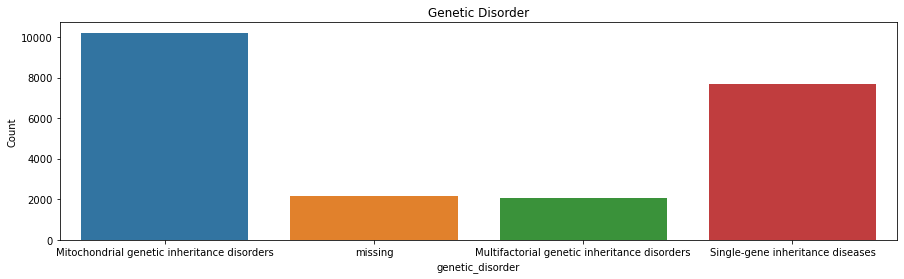

In [19]:
#genetic_disorder
plt.figure(figsize=(15,4))
sns.countplot('genetic_disorder',data=mytarget)
plt.xlabel("genetic_disorder")
plt.ylabel("Count")
plt.title("Genetic Disorder")
plt.show()

In [14]:
mytarget.groupby(['disorder_subclass']).patient_id.nunique()

disorder_subclass
Alzheimer's                             152
Cancer                                   97
Cystic fibrosis                        3448
Diabetes                               1817
Hemochromatosis                        1355
Leber's hereditary optic neuropathy     648
Leigh syndrome                         5160
Mitochondrial myopathy                 4405
Tay-Sachs                              2833
missing                                2168
Name: patient_id, dtype: int64

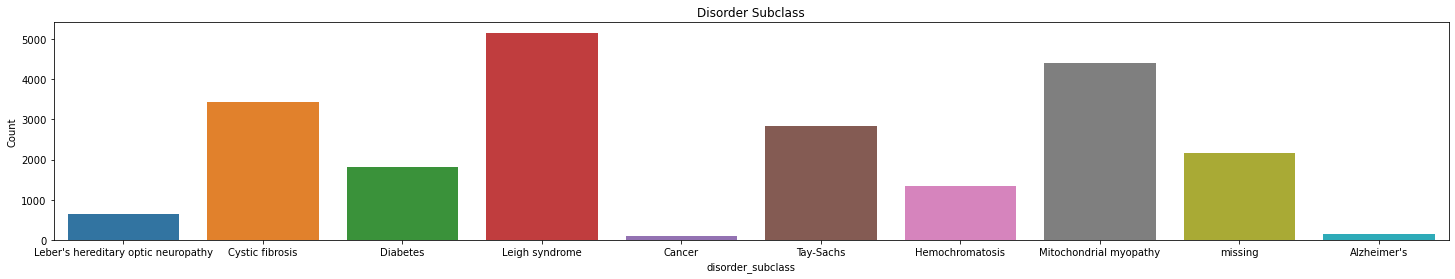

In [22]:
#genetic_disorder
plt.figure(figsize=(25,4))
sns.countplot('disorder_subclass',data=mytarget)
plt.xlabel("disorder_subclass")
plt.ylabel("Count")
plt.title("Disorder Subclass")
plt.show()

In [23]:
## We need to treat missing dependent variable before data prep
## Quickly check the cross tabulations of disorder_subclass and genetic_disorder
t_pivot = mytarget.pivot_table(index='disorder_subclass', 
                               columns='genetic_disorder', 
                               values='patient_id', 
                               aggfunc='nunique',
                               fill_value=0).reset_index()
t_pivot

genetic_disorder                    disorder_subclass  \
0                                         Alzheimer's   
1                                              Cancer   
2                                     Cystic fibrosis   
3                                            Diabetes   
4                                     Hemochromatosis   
5                 Leber's hereditary optic neuropathy   
6                                      Leigh syndrome   
7                              Mitochondrial myopathy   
8                                           Tay-Sachs   
9                                             missing   

genetic_disorder  Mitochondrial genetic inheritance disorders  \
0                                                           0   
1                                                           0   
2                                                           0   
3                                                           0   
4                                                           0   
5                                                         587   
6                                                        4683   
7                                                        3971   
8                                                           0   
9                                                         961   

genetic_disorder  Multifactorial genetic inheritance disorders  \
0                                                          133   
1                                                           91   
2                                                            0   
3                                                         1653   
4                                                            0   
5                                                            0   
6                                                            0   
7                                                            0   
8                                                            0   
9                                                          194   

genetic_disorder  Single-gene inheritance diseases  missing  
0                                                0       19  
1                                                0        6  
2                                             3145      303  
3                                                0      164  
4                                             1228      127  
5                                                0       61  
6                                                0      477  
7                                                0      434  
8                                             2556      277  
9                                              735      278

In [24]:
## From the pivot it is clear that 278 patients both genetic disorder and subcalss are missing (we can drop this sample)
## Treat Genetic disorder column first
t_pivot_d = t_pivot[t_pivot['disorder_subclass']!='missing']
Single_gene_subclass = t_pivot_d[t_pivot_d['Single-gene inheritance diseases']>0]['disorder_subclass'].unique()
Mitochondrial_gene_subclass = t_pivot_d[t_pivot_d['Mitochondrial genetic inheritance disorders']>0]['disorder_subclass'].unique()
Multifactorial_gene_subclass = t_pivot_d[t_pivot_d['Multifactorial genetic inheritance disorders']>0]['disorder_subclass'].unique()

## Create new genetic category
mytarget['genetic_disorder_v1'] = np.where(mytarget['disorder_subclass'].isin(Single_gene_subclass), 'Single-gene inheritance diseases',
                                          np.where(mytarget['disorder_subclass'].isin(Mitochondrial_gene_subclass), 'Mitochondrial genetic inheritance disorders',
                                                  np.where(mytarget['disorder_subclass'].isin(Multifactorial_gene_subclass), 'Multifactorial genetic inheritance disorders', mytarget['genetic_disorder'])))


In [25]:
mytarget.pivot_table(index='disorder_subclass', 
                               columns='genetic_disorder_v1', 
                               values='patient_id', 
                               aggfunc='nunique',
                               fill_value=0).reset_index()

genetic_disorder_v1                    disorder_subclass  \
0                                            Alzheimer's   
1                                                 Cancer   
2                                        Cystic fibrosis   
3                                               Diabetes   
4                                        Hemochromatosis   
5                    Leber's hereditary optic neuropathy   
6                                         Leigh syndrome   
7                                 Mitochondrial myopathy   
8                                              Tay-Sachs   
9                                                missing   

genetic_disorder_v1  Mitochondrial genetic inheritance disorders  \
0                                                              0   
1                                                              0   
2                                                              0   
3                                                              0   
4                                                              0   
5                                                            648   
6                                                           5160   
7                                                           4405   
8                                                              0   
9                                                            961   

genetic_disorder_v1  Multifactorial genetic inheritance disorders  \
0                                                             152   
1                                                              97   
2                                                               0   
3                                                            1817   
4                                                               0   
5                                                               0   
6                                                               0   
7                                                               0   
8                                                               0   
9                                                             194   

genetic_disorder_v1  Single-gene inheritance diseases  missing  
0                                                   0        0  
1                                                   0        0  
2                                                3448        0  
3                                                   0        0  
4                                                1355        0  
5                                                   0        0  
6                                                   0        0  
7                                                   0        0  
8                                                2833        0  
9                                                 735      278

In [26]:
mytarget.head()

patient_id                              genetic_disorder  \
0  PID0x6418   Mitochondrial genetic inheritance disorders   
1  PID0x25d5                                       missing   
2  PID0x4a82  Multifactorial genetic inheritance disorders   
3  PID0x4ac8   Mitochondrial genetic inheritance disorders   
4  PID0x1bf7  Multifactorial genetic inheritance disorders   

                     disorder_subclass  \
0  Leber's hereditary optic neuropathy   
1                      Cystic fibrosis   
2                             Diabetes   
3                       Leigh syndrome   
4                               Cancer   

                            genetic_disorder_v1  
0   Mitochondrial genetic inheritance disorders  
1              Single-gene inheritance diseases  
2  Multifactorial genetic inheritance disorders  
3   Mitochondrial genetic inheritance disorders  
4  Multifactorial genetic inheritance disorders

In [27]:
## Save the new labeled target variable
mytarget.columns = ['patient_id','genetic_disorder_old','disorder_subclass_v1','genetic_disorder_v1']
mytarget.to_csv("mytarget_new.csv")

#### 2 Explore the data attributes (EDA)

In [52]:
df_master = pd.read_csv("df_master.csv")

In [28]:
## chek the data summary
df_master[df_master['myflag']=='train'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22083 entries, 0 to 22082
Data columns (total 46 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   patient_id                                      22083 non-null  object 
 1   patient_age                                     20656 non-null  float64
 2   genes_in_mothers_side                           22083 non-null  object 
 3   inherited_from_father                           21777 non-null  object 
 4   maternal_gene                                   19273 non-null  object 
 5   paternal_gene                                   22083 non-null  object 
 6   blood_cell_count_mcl                            22083 non-null  float64
 7   patient_first_name                              22083 non-null  object 
 8   family_name                                     12392 non-null  object 
 9   fathers_name                           

In [30]:
 ### Lets look at the numeric variable summary
df_master[df_master['myflag']=='train'].describe().transpose()

count       mean        std  \
patient_age                                     20656.0   6.974148   4.319475   
blood_cell_count_mcl                            22083.0   4.898871   0.199663   
mothers_age                                     16047.0  34.526454   9.852598   
fathers_age                                     16097.0  41.972852  13.035501   
test_1                                          19956.0   0.000000   0.000000   
test_2                                          19931.0   0.000000   0.000000   
test_3                                          19936.0   0.000000   0.000000   
test_4                                          19943.0   1.000000   0.000000   
test_5                                          19913.0   0.000000   0.000000   
no._of_previous_abortion                        19921.0   2.003062   1.411919   
white_blood_cell_count_thousand_per_microliter  19935.0   7.486224   2.653393   
symptom_1                                       19928.0   0.592483   0.491385   
symptom_2                                       19861.0   0.551886   0.497313   
symptom_3                                       19982.0   0.536233   0.498698   
symptom_4                                       19970.0   0.497747   0.500007   
symptom_5                                       19930.0   0.461917   0.498560   

                                                      min        25%  \
patient_age                                      0.000000   3.000000   
blood_cell_count_mcl                             4.092727   4.763109   
mothers_age                                     18.000000  26.000000   
fathers_age                                     20.000000  31.000000   
test_1                                           0.000000   0.000000   
test_2                                           0.000000   0.000000   
test_3                                           0.000000   0.000000   
test_4                                           1.000000   1.000000   
test_5                                           0.000000   0.000000   
no._of_previous_abortion                         0.000000   1.000000   
white_blood_cell_count_thousand_per_microliter   3.000000   5.424703   
symptom_1                                        0.000000   0.000000   
symptom_2                                        0.000000   0.000000   
symptom_3                                        0.000000   0.000000   
symptom_4                                        0.000000   0.000000   
symptom_5                                        0.000000   0.000000   

                                                      50%        75%  \
patient_age                                      7.000000  11.000000   
blood_cell_count_mcl                             4.899399   5.033830   
mothers_age                                     35.000000  43.000000   
fathers_age                                     42.000000  53.000000   
test_1                                           0.000000   0.000000   
test_2                                           0.000000   0.000000   
test_3                                           0.000000   0.000000   
test_4                                           1.000000   1.000000   
test_5                                           0.000000   0.000000   
no._of_previous_abortion                         2.000000   3.000000   
white_blood_cell_count_thousand_per_microliter   7.477132   9.526152   
symptom_1                                        1.000000   1.000000   
symptom_2                                        1.000000   1.000000   
symptom_3                                        1.000000   1.000000   
symptom_4                                        0.000000   1.000000   
symptom_5                                        0.000000   1.000000   

                                                      max  
patient_age                                     14.000000  
blood_cell_count_mcl                             5.609829  
mothers_age                               

###### function to create data dictionary

In [95]:
def summary_stat (df):
    missing_cnt = df.isnull().sum()
    missing_prop = round(100*df.isnull().sum()/len(df),2)
    uniqv = df.apply(lambda x: x.nunique())
    ctype = df.apply(lambda x: x.dtype)
    mydf = pd.DataFrame({'Column Type':ctype, 'Number of Unique':uniqv, 'Total missing':missing_cnt, 'missing percentage':missing_prop})
    return(mydf)

In [32]:
data_dictinary = summary_stat(df_master)
data_dictinary = data_dictinary.reset_index()
data_dictinary.head()

index Column Type  Number of Unique  Total missing  \
0             patient_id      object             31548              0   
1            patient_age     float64                15           1427   
2  genes_in_mothers_side      object                 2              0   
3  inherited_from_father      object                 2            857   
4          maternal_gene      object                 2           6533   

   missing percentage  
0                0.00  
1                4.52  
2                0.00  
3                2.72  
4               20.71

In [33]:
#### Lets check different types of data
all_variable = df_master.columns.to_list()
print("Total variables in the master data set: ", len(all_variable))
drop_var_from_ana = ['patient_first_name', 'family_name','fathers_name']
print("We can drop some of the variables which are not really important: ", len(drop_var_from_ana))
variable_no_missing = data_dictinary[data_dictinary['Total missing']==0]['index'].to_list()
print("Total variable has complete data: ", len(variable_no_missing))
variable_with_missing = data_dictinary[data_dictinary['Total missing']!=0]['index'].to_list()
print("Total variable has missing data: ", len(variable_with_missing))
total_cat_var = data_dictinary[data_dictinary['Column Type']=='object']['index'].to_list()
print("Total categorical variable: ", len(total_cat_var))
total_num_var = data_dictinary[data_dictinary['Column Type']!='object']['index'].to_list()
print("Total numerical variable: ", len(total_num_var))

Total variables in the master data set:  46
We can drop some of the variables which are not really important:  3
Total variable has complete data:  9
Total variable has missing data:  37
Total categorical variable:  30
Total numerical variable:  16


In [34]:
### Checking the unique values from all the missing variable
for j in all_variable:
    print(j)
    print(df_master[j].unique())
    print('==================','\n')

patient_id
['PID0x6418' 'PID0x25d5' 'PID0x4a82' ... 'PID0x5408' 'PID0x2017'
 'PID0x7f61']

patient_age
[ 2.  4.  6. 12. 11. 14.  3.  7.  1.  0. nan 10.  5. 13.  8.  9.]

genes_in_mothers_side
['Yes' 'No']

inherited_from_father
['No' 'Yes' nan]

maternal_gene
['Yes' 'No' nan]

paternal_gene
['No' 'Yes']

blood_cell_count_mcl
[4.76060309 4.91066906 4.89329743 ... 4.89835233 4.80483966 5.42123643]

patient_first_name
['Richard' 'Mike' 'Kimberly' ... 'Alejandrina' 'Karolyn' 'Jerrod']

family_name
[nan 'Hoelscher' 'Stutzman' ... 'Rodrigue' 'Lebron' 'Dilworth']

fathers_name
['Larre' 'Brycen' 'Nashon' ... 'Shamond' 'Nasir' 'Jatorian']

mothers_age
[nan 41. 21. 32. 40. 45. 44. 50. 28. 30. 24. 36. 51. 23. 49. 46. 18. 38.
 37. 42. 48. 25. 19. 47. 34. 35. 22. 33. 20. 26. 31. 29. 27. 43. 39.]

fathers_age
[nan 23. 22. 63. 44. 42. 56. 20. 24. 57. 48. 30. 55. 62. 43. 32. 41. 52.
 28. 31. 61. 35. 49. 50. 29. 64. 39. 34. 51. 25. 60. 53. 58. 26. 27. 59.
 47. 38. 54. 21. 37. 36. 33. 46. 40. 45.]

inst

##### Lets quickly run the EDA using Auto EDA 
Pandas Profiling gives the overview of all the features

In [36]:
import pandas_profiling
df_master[df_master.myflag=='train'].profile_report()

##### Cleaning the missing value features and Feature engineering

In [37]:
### Value Corrections on master data
df_master['institute_name'] = np.where(df_master['institute_name'] == '-99', np.nan, df_master['institute_name'])
df_master['mcap_institute_name'] = np.where(df_master['institute_name'].isnull(), 1, 0)
df_master['institute_name'] = np.where(df_master['institute_name'].isnull(), 'Not applicable', df_master['institute_name'])

df_master['respiratory_rate_breathsmin'] = np.where(df_master['respiratory_rate_breathsmin'] == '-99',np.nan, df_master['respiratory_rate_breathsmin'])
df_master['mcap_respiratory_rate_breathsmin'] = np.where(df_master['respiratory_rate_breathsmin'].isnull(),1, 0)

df_master['heart_rate_ratesmin'] = np.where(df_master['heart_rate_ratesmin'] == '-99', np.nan, df_master['heart_rate_ratesmin'])
df_master['mcap_heart_rate_ratesmin'] = np.where(df_master['heart_rate_ratesmin'].isnull(), 1, 0)

In [38]:
## treat -99 as nan
df_master['test_1'] = np.where(df_master['test_1']==-99, np.nan, df_master['test_1'])
df_master['test_2'] = np.where(df_master['test_2']==-99, np.nan, df_master['test_2'])
df_master['test_3'] = np.where(df_master['test_3']==-99, np.nan, df_master['test_3'])
df_master['test_4'] = np.where(df_master['test_4']==-99, np.nan, df_master['test_4'])
df_master['test_5'] = np.where(df_master['test_5']==-99, np.nan, df_master['test_5'])

## combine all test to create new categorical data 
cols = ['test_1','test_2','test_3','test_4','test_5']
df_master['test_1to5'] = df_master[cols].fillna(9).apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

## Replace NaN as constant value
df_master[cols] = df_master[cols].fillna(99)

In [39]:
df_master['parental_consent'] = np.where(df_master['parental_consent'] == '-99', np.nan, df_master['parental_consent'])
df_master['parental_consent'] = np.where(df_master['parental_consent'].isnull(), 'No', df_master['parental_consent'])

df_master['followup'] = np.where(df_master['followup'] == '-99', np.nan, df_master['followup'])
df_master['mcap_followup'] = np.where(df_master['followup'].isnull(), 1, 0)
df_master['followup'] = np.where(df_master['followup'].isnull(), 'Missing', df_master['followup'])

df_master['gender'] = np.where(df_master['gender'] == '-99', np.nan, df_master['gender'])
df_master['mcap_gender'] = np.where(df_master['gender'].isnull(), 1, 0)
df_master['gender'] = np.where(df_master['gender'].isnull(), 'Missing', df_master['gender'])

In [40]:
df_master['birth_asphyxia'] = np.where(df_master['birth_asphyxia'] == '-99', np.nan, df_master['birth_asphyxia'])
df_master['mcap_birth_asphyxia'] = np.where(df_master['birth_asphyxia'].isnull(), 1, 0)
df_master['birth_asphyxia'] = np.where(df_master['birth_asphyxia'].isin(['No record','Not available']), 'Not available', df_master['birth_asphyxia'])

In [41]:
df_master['autopsy_shows_birth_defect_if_applicable'] = np.where(df_master['autopsy_shows_birth_defect_if_applicable'] == '-99', np.nan, df_master['autopsy_shows_birth_defect_if_applicable'])
df_master['mcap_autopsy_shows_birth_defect_if_applicable'] = np.where(df_master['autopsy_shows_birth_defect_if_applicable'].isnull(), 1, 0)
df_master['autopsy_shows_birth_defect_if_applicable'] = np.where(df_master['autopsy_shows_birth_defect_if_applicable'].isin(['None','No']), 'No', df_master['autopsy_shows_birth_defect_if_applicable'])

In [42]:
df_master['place_of_birth'] = np.where(df_master['place_of_birth'] == '-99', np.nan, df_master['place_of_birth'])
df_master['mcap_place_of_birth'] = np.where(df_master['place_of_birth'].isnull(), 1, 0)
df_master['place_of_birth'] = np.where(df_master['place_of_birth'].isnull(), 'Not available', df_master['place_of_birth'])

In [43]:
df_master['folic_acid_details_periconceptional'] = np.where(df_master['folic_acid_details_periconceptional'] == '-99', np.nan, df_master['folic_acid_details_periconceptional'])
df_master['mcap_folic_acid_details_periconceptional'] = np.where(df_master['folic_acid_details_periconceptional'].isnull(), 1, 0)
#df_master['folic_acid_details_periconceptional'] = np.where(df_master['folic_acid_details_periconceptional'].isnull(), 'No', df_master['folic_acid_details_periconceptional'])

df_master['ho_serious_maternal_illness'] = np.where(df_master['ho_serious_maternal_illness'] == '-99', np.nan, df_master['ho_serious_maternal_illness'])
df_master['mcap_ho_serious_maternal_illness'] = np.where(df_master['ho_serious_maternal_illness'].isnull(), 1, 0)

## New derived feature
df_master['flag_ho_serious_maternal_folic_acid'] = np.where((df_master['ho_serious_maternal_illness']=='Yes') & (df_master['folic_acid_details_periconceptional']=='Yes'), 1, 0)

In [44]:
df_master['ho_serious_maternal_illness'] = np.where(df_master['ho_serious_maternal_illness'] == '-99', np.nan, df_master['ho_serious_maternal_illness'])
df_master['mcap_ho_serious_maternal_illness'] = np.where(df_master['ho_serious_maternal_illness'].isnull(), 1, 0)

In [45]:
df_master['ho_radiation_exposure_xray'] = np.where(df_master['ho_radiation_exposure_xray'].isin(['-99', '-']), np.nan, df_master['ho_radiation_exposure_xray'])
df_master['mcap_ho_radiation_exposure_xray'] = np.where(df_master['ho_radiation_exposure_xray'].isnull(), 1, 0)

df_master['ho_substance_abuse'] = np.where(df_master['ho_substance_abuse'].isin(['-99', '-']), np.nan, df_master['ho_substance_abuse'])
df_master['mcap_ho_substance_abuse'] = np.where(df_master['ho_substance_abuse'].isnull(), 1, 0)

## New derived feature
df_master['flag_ho_substance_abuse_radiation'] = np.where((df_master['ho_substance_abuse']=='Yes') & (df_master['ho_radiation_exposure_xray']=='Yes'), 1, 0)

In [46]:
df_master['assisted_conception_ivfart'] = np.where(df_master['assisted_conception_ivfart'].isin(['-99', '-']), np.nan, df_master['assisted_conception_ivfart'])
df_master['mcap_assisted_conception_ivfart'] = np.where(df_master['assisted_conception_ivfart'].isnull(), 1, 0)

df_master['history_of_anomalies_in_previous_pregnancies'] = np.where(df_master['history_of_anomalies_in_previous_pregnancies'].isin(['-99', '-']), np.nan, df_master['history_of_anomalies_in_previous_pregnancies'])
df_master['mcap_history_of_anomalies_in_previous_pregnancies'] = np.where(df_master['history_of_anomalies_in_previous_pregnancies'].isnull(), 1, 0)

# Derived Feature
df_master['flag_history_of_anomalies_ivfart'] = np.where((df_master['assisted_conception_ivfart']=='Yes') & (df_master['history_of_anomalies_in_previous_pregnancies']=='Yes'), 1, 0)


In [47]:
df_master['no._of_previous_abortion'] = np.where(df_master['no._of_previous_abortion']==-99, np.nan, df_master['no._of_previous_abortion'])

df_master['birth_defects'] = np.where(df_master['birth_defects']=='-99', np.nan, df_master['birth_defects'])
df_master['mcap_birth_defects'] = np.where(df_master['birth_defects'].isnull(), 1, 0)

df_master['blood_test_result'] = np.where(df_master['blood_test_result']=='-99', np.nan, df_master['blood_test_result'])
df_master['mcap_blood_test_result'] = np.where(df_master['blood_test_result'].isnull(), 1,0)

In [48]:
cols = ['symptom_1','symptom_2','symptom_3','symptom_4', 'symptom_5']
df_master['mcap_symptom_1to_5'] = np.where((df_master['symptom_1'].isnull()) | (df_master['symptom_2'].isnull())
                                           | (df_master['symptom_3'].isnull())| (df_master['symptom_4'].isnull())| (df_master['symptom_5'].isnull()), 1, 0)
df_master[cols] = df_master[cols].fillna(0)
df_master['symptom_1to_5'] = df_master[cols].fillna(9).apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [50]:
### run the data dictionary on all the data
data_dictinary = summary_stat(df_master)
data_dictinary = data_dictinary.reset_index()
all_variable = df_master.columns.to_list()
print("Total variables in the master data set: ", len(all_variable))
drop_var_from_ana = ['patient_first_name', 'family_name','fathers_name']
print("We can drop some of the variables which are not really important: ", len(drop_var_from_ana))

print("----------------------------------------------------------------")
total_cat_var = data_dictinary[data_dictinary['Column Type']=='object']['index'].to_list()
print("Total categorical variable: ", len(total_cat_var))
total_num_var = data_dictinary[data_dictinary['Column Type']!='object']['index'].to_list()
print("Total numerical variable: ", len(total_num_var))

print("----------------------------------------------------------------")
variable_no_missing = data_dictinary[data_dictinary['Total missing']==0]['index'].to_list()
print("Total variable no missing data: ", len(variable_no_missing))

variable_no_missing_cat = data_dictinary[(data_dictinary['Total missing']==0) & (data_dictinary['Column Type']=='object')]['index'].to_list()
print("Total categorical variable has complete data: ", len(variable_no_missing_cat))
variable_no_missing_num = data_dictinary[(data_dictinary['Total missing']==0) & (data_dictinary['Column Type']!='object')]['index'].to_list()
print("Total numeric variable has complete data: ", len(variable_no_missing_num))

print("----------------------------------------------------------------")

variable_with_missing = data_dictinary[data_dictinary['Total missing']!=0]['index'].to_list()
print("Total variable has missing data: ", len(variable_with_missing))

variable_missing_cat = data_dictinary[(data_dictinary['Total missing']!=0) & (data_dictinary['Column Type']=='object')]['index'].to_list()
print("Total categorical variable has missing data: ", len(variable_missing_cat))
variable_missing_num = data_dictinary[(data_dictinary['Total missing']!=0) & (data_dictinary['Column Type']!='object')]['index'].to_list()
print("Total numeric variable has missing data: ", len(variable_missing_num))


Total variables in the master data set:  68
We can drop some of the variables which are not really important:  3
----------------------------------------------------------------
Total categorical variable:  32
Total numerical variable:  36
----------------------------------------------------------------
Total variable no missing data:  46
Total categorical variable has complete data:  15
Total numeric variable has complete data:  31
----------------------------------------------------------------
Total variable has missing data:  22
Total categorical variable has missing data:  17
Total numeric variable has missing data:  5


In [51]:
### Some of the variable we can drop directly
drop_var_from_mi = ['patient_first_name', 'family_name','fathers_name', 'location_of_institute', 'institute_name','patient_id', 'genetic_disorder','disorder_subclass']
### Take the Copy of master data to impute the missing value
imputate_data = df_master.copy()
imputate_data.index = imputate_data.patient_id ## Add index name as patient id
#imputate_data = imputate_data[my_var_selected]

In [52]:
imputate_data.myflag.head()

patient_id
PID0x6418    train
PID0x25d5    train
PID0x4a82    train
PID0x4ac8    train
PID0x1bf7    train
Name: myflag, dtype: object

In [53]:
data_dictinary = summary_stat(imputate_data)
data_dictinary = data_dictinary.reset_index()
data_dictinary = data_dictinary[~data_dictinary['index'].isin(drop_var_from_mi)]
my_var_selected = set(data_dictinary['index'].to_list())
print("----------------------------------------------------------------")
total_cat_var = data_dictinary[data_dictinary['Column Type']=='object']['index'].to_list()
print("Total categorical variable: ", len(total_cat_var))
total_num_var = data_dictinary[data_dictinary['Column Type']!='object']['index'].to_list()
print("Total numerical variable: ", len(total_num_var))

print("----------------------------------------------------------------")
variable_no_missing = data_dictinary[data_dictinary['Total missing']==0]['index'].to_list()
print("Total variable no missing data: ", len(variable_no_missing))

variable_no_missing_cat = data_dictinary[(data_dictinary['Total missing']==0) & (data_dictinary['Column Type']=='object')]['index'].to_list()
print("Total categorical variable has complete data: ", len(variable_no_missing_cat))
variable_no_missing_num = data_dictinary[(data_dictinary['Total missing']==0) & (data_dictinary['Column Type']!='object')]['index'].to_list()
print("Total numeric variable has complete data: ", len(variable_no_missing_num))

print("----------------------------------------------------------------")

variable_with_missing = data_dictinary[data_dictinary['Total missing']!=0]['index'].to_list()
print("Total variable has missing data: ", len(variable_with_missing))

variable_missing_cat = data_dictinary[(data_dictinary['Total missing']!=0) & (data_dictinary['Column Type']=='object')]['index'].to_list()
print("Total categorical variable has missing data: ", len(variable_missing_cat))
variable_missing_num = data_dictinary[(data_dictinary['Total missing']!=0) & (data_dictinary['Column Type']!='object')]['index'].to_list()
print("Total numeric variable has missing data: ", len(variable_missing_num))


----------------------------------------------------------------
Total categorical variable:  24
Total numerical variable:  36
----------------------------------------------------------------
Total variable no missing data:  41
Total categorical variable has complete data:  10
Total numeric variable has complete data:  31
----------------------------------------------------------------
Total variable has missing data:  19
Total categorical variable has missing data:  14
Total numeric variable has missing data:  5


#### Missing Variable imputation using RF algorithms

##### Predict categorical data missing values

In [54]:
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.ensemble import RandomForestRegressor
from collections import Counter

In [55]:
### Create dummy coding funcntion
def my_dummy_var (data, varlist):
    sparse_mat = pd.get_dummies(data[varlist]).rename(columns=lambda x: 'dummy_' + str(x))
    sparse_mat_names = sparse_mat.columns.to_list()
    sparse_mat_names = [w.replace('-', '_') for w in sparse_mat_names]
    sparse_mat_names = [w.lower() for w in sparse_mat_names]
    sparse_mat.columns = sparse_mat_names
    return(sparse_mat)    

In [57]:
### Random Forest missing variable imputations for both numeric and categorical data
def cat_rf_imputation (mydata, my_var_selected, dep_var, ntree=500, seed=123, method = 'class'):
    data = mydata.copy()
    imputation_variable = set(my_var_selected)-set('myflag')
    #dep_var = ['ho_radiation_exposure_xray']
    iv_var = set(imputation_variable) - set(dep_var)
    dummy_iv = set(variable_missing_cat)
    dummy_iv = dummy_iv.union(set(variable_no_missing_cat))-set(dep_var)
    numeric_iv = set(variable_no_missing_num)
    numeric_iv = numeric_iv.union(set(variable_missing_num)) - set(dep_var)
    
    if method == 'class' :
        print(data[dep_var].value_counts())
    if method == 'reg' :
        print(data[dep_var].describe())
    
    ## Create Train and Score df
    train_df = data[data[dep_var].notnull().values].copy()
    print("Train data", train_df.shape)
    score_df = data[data[dep_var].isnull().values].copy()
    print("Score data",score_df.shape)
    
    ## Create Dummy coding
    dummy_var = my_dummy_var(data, dummy_iv)
    train_dummy_df = dummy_var.loc[train_df.index]
    score_dummy_df = dummy_var.loc[score_df.index]

    X = pd.concat([train_df[numeric_iv], train_dummy_df], axis=1)
    X.fillna(0, inplace=True)
    Z = pd.concat([score_df[numeric_iv], score_dummy_df], axis=1)
    Z.fillna(0, inplace=True)
    
    # Split dataset into training set and test set
    y = train_df[dep_var]
    y.columns = ['my_target']
    X_train, X_test, y_train, y_test = train_test_split(X, y.my_target.values, test_size=0.2) 
    
    #Import Random Forest Model
    #from sklearn.ensemble import RandomForestClassifier, BalancedRandomForestClassifier
    #Create a Gaussian Classifier
    if method=='class':
        clf=BalancedRandomForestClassifier(n_estimators=ntree, random_state=seed)

        #Train the model using the training sets y_pred=clf.predict(X_test)
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        print(dep_var, "accuaracy is ", balanced_accuracy_score(y_test, y_pred))
        y_score=clf.predict(Z)
        Z[dep_var] = y_score
        data.loc[Z.index, dep_var] = Z[dep_var]
        myimputed_data = data[dep_var]
        return(myimputed_data)
    if method=='reg':
        
        regr = RandomForestRegressor(max_depth=2, n_estimators=ntree, random_state=seed)
        regr.fit(X_train,y_train)
        y_pred=regr.predict(X_test)
        y_score=regr.predict(Z)
        Z[dep_var] = y_score
        data.loc[Z.index, dep_var] = Z[dep_var]
        myimputed_data = data[dep_var]
        return(myimputed_data)

In [59]:
 variable_missing_num ## Numerical variable has missing

['patient_age',
 'mothers_age',
 'fathers_age',
 'no._of_previous_abortion',
 'white_blood_cell_count_thousand_per_microliter']

In [60]:
### Numerical variable imputation
for j in range(len(variable_missing_num)):
    print("imputation for ",variable_missing_num[j])
    cc = cat_rf_imputation(imputate_data, my_var_selected, dep_var= [variable_missing_num[j]], ntree=500, seed=123, method = 'reg')
    if j==0:
        mydata_imp_num = cc
    if j!=0:
        mydata_imp_num = pd.concat([mydata_imp_num, cc], axis=1)
    del(cc)

imputation for  patient_age
        patient_age
count  30121.000000
mean       6.995418
std        4.325345
min        0.000000
25%        3.000000
50%        7.000000
75%       11.000000
max       14.000000
Train data (30121, 68)
Score data (1427, 68)
imputation for  mothers_age
        mothers_age
count  25512.000000
mean      34.544646
std        9.845861
min       18.000000
25%       26.000000
50%       35.000000
75%       43.000000
max       51.000000
Train data (25512, 68)
Score data (6036, 68)
imputation for  fathers_age
        fathers_age
count  25562.000000
mean      41.920233
std       13.037442
min       20.000000
25%       30.000000
50%       42.000000
75%       53.000000
max       64.000000
Train data (25562, 68)
Score data (5986, 68)
imputation for  no._of_previous_abortion
       no._of_previous_abortion
count              27290.000000
mean                   2.006852
std                    1.411019
min                    0.000000
25%                    1.000000
50%     

In [61]:
### cheking if there any missing value after the imputation
mydata_imp_num.isnull().sum()

patient_age                                       0
mothers_age                                       0
fathers_age                                       0
no._of_previous_abortion                          0
white_blood_cell_count_thousand_per_microliter    0
dtype: int64

In [62]:
mydata_imp_num.head()

patient_age  mothers_age  fathers_age  no._of_previous_abortion  \
patient_id                                                                    
PID0x6418           2.0    34.789336    41.783074                  2.044744   
PID0x25d5           4.0    34.440669    23.000000                  2.013425   
PID0x4a82           6.0    41.000000    22.000000                  4.000000   
PID0x4ac8          12.0    21.000000    42.046237                  1.000000   
PID0x1bf7          11.0    32.000000    42.095680                  4.000000   

            white_blood_cell_count_thousand_per_microliter  
patient_id                                                  
PID0x6418                                         9.857562  
PID0x25d5                                         5.522560  
PID0x4a82                                         7.485191  
PID0x4ac8                                         7.919321  
PID0x1bf7                                         4.098210

In [63]:
variable_missing_cat ### Variable has missing on categorical side

['inherited_from_father',
 'maternal_gene',
 'respiratory_rate_breathsmin',
 'heart_rate_ratesmin',
 'birth_asphyxia',
 'autopsy_shows_birth_defect_if_applicable',
 'folic_acid_details_periconceptional',
 'ho_serious_maternal_illness',
 'ho_radiation_exposure_xray',
 'ho_substance_abuse',
 'assisted_conception_ivfart',
 'history_of_anomalies_in_previous_pregnancies',
 'birth_defects',
 'blood_test_result']

In [64]:
### Categorical variable imputation
for j in range(len(variable_missing_cat)):
    print("imputation for ",variable_missing_cat[j])
    cc = cat_rf_imputation(imputate_data, my_var_selected, dep_var= [variable_missing_cat[j]], ntree=500, seed=123, method = 'class')
    if j==0:
        mydata_imp_cat = cc
    if j!=0:
        mydata_imp_cat = pd.concat([mydata_imp_cat, cc], axis=1)
    del(cc)

imputation for  inherited_from_father
inherited_from_father
No                       18576
Yes                      12115
dtype: int64
Train data (30691, 68)
Score data (857, 68)
['inherited_from_father'] accuaracy is  0.5371868401719755
imputation for  maternal_gene
maternal_gene
Yes              13902
No               11113
dtype: int64
Train data (25015, 68)
Score data (6533, 68)
['maternal_gene'] accuaracy is  0.5411017713796737
imputation for  respiratory_rate_breathsmin
respiratory_rate_breathsmin
Normal (30-60)                 12328
Tachypnea                      12080
dtype: int64
Train data (24408, 68)
Score data (7140, 68)
['respiratory_rate_breathsmin'] accuaracy is  0.5122474338658042
imputation for  heart_rate_ratesmin
heart_rate_ratesmin
Normal                 12408
Tachycardia            12053
dtype: int64
Train data (24461, 68)
Score data (7087, 68)
['heart_rate_ratesmin'] accuaracy is  0.5023557551097331
imputation for  birth_asphyxia
birth_asphyxia
Not available     1

In [66]:
mydata_imp_cat.head()

inherited_from_father maternal_gene respiratory_rate_breathsmin  \
patient_id                                                                   
PID0x6418                     No           Yes              Normal (30-60)   
PID0x25d5                    Yes            No                   Tachypnea   
PID0x4a82                     No            No              Normal (30-60)   
PID0x4ac8                     No           Yes                   Tachypnea   
PID0x1bf7                     No            No                   Tachypnea   

           heart_rate_ratesmin birth_asphyxia  \
patient_id                                      
PID0x6418               Normal            Yes   
PID0x25d5               Normal             No   
PID0x4a82          Tachycardia  Not available   
PID0x4ac8               Normal  Not available   
PID0x1bf7          Tachycardia  Not available   

           autopsy_shows_birth_defect_if_applicable  \
patient_id                                            
PID0x6418                            Not applicable   
PID0x25d5                                        No   
PID0x4a82                            Not applicable   
PID0x4ac8                                        No   
PID0x1bf7                            Not applicable   

           folic_acid_details_periconceptional ho_serious_maternal_illness  \
patient_id                                                                   
PID0x6418                                   No                          No   
PID0x25d5                                  Yes                         Yes   
PID0x4a82                                  Yes                          No   
PID0x4ac8                                   No                         Yes   
PID0x1bf7                                   No                         Yes   

           ho_radiation_exposure_xray ho_substance_abuse  \
patient_id                                                 
PID0x6418                          No                 No   
PID0x25d5              Not applicable     Not applicable   
PID0x4a82                         Yes     Not applicable   
PID0x4ac8                          No     Not applicable   
PID0x1bf7              Not applicable     Not applicable   

           assisted_conception_ivfart  \
patient_id                              
PID0x6418                          No   
PID0x25d5                          No   
PID0x4a82                         Yes   
PID0x4ac8                          No   
PID0x1bf7                         Yes   

           history_of_anomalies_in_previous_pregnancies birth_defects  \
patient_id                                                              
PID0x6418                                           Yes      Multiple   
PID0x25d5                                           Yes      Multiple   
PID0x4a82                                           Yes      Singular   
PID0x4ac8                                           Yes      Singular   
PID0x1bf7                                            No      Multiple   

           blood_test_result  
patient_id                    
PID0x6418       inconclusive  
PID0x25d5             normal  
PID0x4a82             normal  
PID0x4ac8       inconclusive  
PID0x1bf7           abnormal

In [67]:
col = imputate_data.columns
col

Index(['patient_id', 'patient_age', 'genes_in_mothers_side',
       'inherited_from_father', 'maternal_gene', 'paternal_gene',
       'blood_cell_count_mcl', 'patient_first_name', 'family_name',
       'fathers_name', 'mothers_age', 'fathers_age', 'institute_name',
       'location_of_institute', 'status', 'respiratory_rate_breathsmin',
       'heart_rate_ratesmin', 'test_1', 'test_2', 'test_3', 'test_4', 'test_5',
       'parental_consent', 'followup', 'gender', 'birth_asphyxia',
       'autopsy_shows_birth_defect_if_applicable', 'place_of_birth',
       'folic_acid_details_periconceptional', 'ho_serious_maternal_illness',
       'ho_radiation_exposure_xray', 'ho_substance_abuse',
       'assisted_conception_ivfart',
       'history_of_anomalies_in_previous_pregnancies',
       'no._of_previous_abortion', 'birth_defects',
       'white_blood_cell_count_thousand_per_microliter', 'blood_test_result',
       'symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5',
       'genetic

In [68]:
## Define the variable bucket 
missing_flag = [col for col in  imputate_data.columns if 'mcap_' in col] ## Missing indicator flag variable
other_flag = [col for col in  imputate_data.columns if 'flag_' in col]   ## Other derived variables (Combinations of more than one categorical data)
other_flag

['flag_ho_serious_maternal_folic_acid',
 'flag_ho_substance_abuse_radiation',
 'flag_history_of_anomalies_ivfart']

In [69]:
mydata_imp_cat['maternal_gene'].value_counts()

Yes    17342
No     14206
Name: maternal_gene, dtype: int64

In [70]:
imputate_data[variable_no_missing_cat]

genes_in_mothers_side paternal_gene    status parental_consent  \
patient_id                                                                  
PID0x6418                    Yes            No     Alive              Yes   
PID0x25d5                    Yes            No  Deceased              Yes   
PID0x4a82                    Yes            No     Alive              Yes   
PID0x4ac8                    Yes            No  Deceased              Yes   
PID0x1bf7                    Yes           Yes     Alive               No   
...                          ...           ...       ...              ...   
PID0x81e1                    Yes            No     Alive              Yes   
PID0x3514                    Yes           Yes  Deceased              Yes   
PID0x5408                     No            No  Deceased              Yes   
PID0x2017                     No            No     Alive              Yes   
PID0x7f61                     No           Yes  Deceased              Yes   

           followup     gender place_of_birth myflag            test_1to5  \
patient_id                                                                  
PID0x6418      High    Missing      Institute  train  0.0_9.0_9.0_1.0_0.0   
PID0x25d5      High    Missing  Not available  train  9.0_0.0_0.0_1.0_0.0   
PID0x4a82       Low    Missing  Not available  train  0.0_0.0_0.0_1.0_0.0   
PID0x4ac8      High       Male      Institute  train  0.0_0.0_0.0_1.0_0.0   
PID0x1bf7       Low       Male      Institute  train  0.0_0.0_0.0_1.0_0.0   
...             ...        ...            ...    ...                  ...   
PID0x81e1       Low    Missing      Institute   test  9.0_0.0_9.0_1.0_9.0   
PID0x3514   Missing       Male      Institute   test  0.0_0.0_9.0_1.0_9.0   
PID0x5408   Missing     Female      Institute   test  9.0_0.0_0.0_1.0_0.0   
PID0x2017      High    Missing           Home   test  0.0_0.0_0.0_1.0_0.0   
PID0x7f61       Low  Ambiguous           Home   test  0.0_9.0_0.0_1.0_0.0   

                  symptom_1to_5  
patient_id                       
PID0x6418   1.0_1.0_1.0_1.0_1.0  
PID0x25d5   1.0_0.0_1.0_1.0_0.0  
PID0x4a82   0.0_1.0_1.0_1.0_1.0  
PID0x4ac8   0.0_0.0_1.0_0.0_0.0  
PID0x1bf7   0.0_0.0_0.0_0.0_0.0  
...                         ...  
PID0x81e1   0.0_1.0_1.0_1.0_0.0  
PID0x3514   0.0_1.0_0.0_1.0_1.0  
PID0x5408   0.0_1.0_0.0_0.0_1.0  
PID0x2017   1.0_1.0_1.0_1.0_1.0  
PID0x7f61   1.0_1.0_1.0_1.0_1.0  

[31548 rows x 10 columns]

In [71]:
### Lets Combine all the data 
missing_flag = [col for col in  imputate_data.columns if 'mcap_' in col]
other_flag = [col for col in  imputate_data.columns if 'flag_' in col]
keep_var_list = variable_no_missing_num+variable_no_missing_cat+['genetic_disorder','disorder_subclass']
print(imputate_data[keep_var_list].isnull().sum())
mymaster = pd.concat([mydata_imp_num, mydata_imp_cat, imputate_data[keep_var_list]], axis=1)
#mymaster.to_csv("after_imputation_master_data.csv")
data_dictinary = summary_stat(mymaster)
data_dictinary = data_dictinary.reset_index()
all_variable = df_master.columns.to_list()
data_dictinary

blood_cell_count_mcl                                     0
test_1                                                   0
test_2                                                   0
test_3                                                   0
test_4                                                   0
test_5                                                   0
symptom_1                                                0
symptom_2                                                0
symptom_3                                                0
symptom_4                                                0
symptom_5                                                0
mcap_institute_name                                      0
mcap_respiratory_rate_breathsmin                         0
mcap_heart_rate_ratesmin                                 0
mcap_followup                                            0
mcap_gender                                              0
mcap_birth_asphyxia                                     

index Column Type  \
0                                      patient_age     float64   
1                                      mothers_age     float64   
2                                      fathers_age     float64   
3                         no._of_previous_abortion     float64   
4   white_blood_cell_count_thousand_per_microliter     float64   
..                                             ...         ...   
57                                          myflag      object   
58                                       test_1to5      object   
59                                   symptom_1to_5      object   
60                                genetic_disorder      object   
61                               disorder_subclass      object   

    Number of Unique  Total missing  missing percentage  
0               1442              0                0.00  
1               6070              0                0.00  
2               6031              0                0.00  
3               4263              0                0.00  
4              25801              0                0.00  
..               ...            ...                 ...  
57                 2              0                0.00  
58                32              0                0.00  
59                32              0                0.00  
60                 3          11611               36.80  
61                 9          11633               36.87  

[62 rows x 5 columns]

In [72]:
mytarget.head()

patient_id                          genetic_disorder_old  \
0  PID0x6418   Mitochondrial genetic inheritance disorders   
1  PID0x25d5                                       missing   
2  PID0x4a82  Multifactorial genetic inheritance disorders   
3  PID0x4ac8   Mitochondrial genetic inheritance disorders   
4  PID0x1bf7  Multifactorial genetic inheritance disorders   

                  disorder_subclass_v1  \
0  Leber's hereditary optic neuropathy   
1                      Cystic fibrosis   
2                             Diabetes   
3                       Leigh syndrome   
4                               Cancer   

                            genetic_disorder_v1  
0   Mitochondrial genetic inheritance disorders  
1              Single-gene inheritance diseases  
2  Multifactorial genetic inheritance disorders  
3   Mitochondrial genetic inheritance disorders  
4  Multifactorial genetic inheritance disorders

In [73]:
### Reset Index
mymaster = mymaster.reset_index()
mymaster.head()

patient_id  patient_age  mothers_age  fathers_age  no._of_previous_abortion  \
0  PID0x6418          2.0    34.789336    41.783074                  2.044744   
1  PID0x25d5          4.0    34.440669    23.000000                  2.013425   
2  PID0x4a82          6.0    41.000000    22.000000                  4.000000   
3  PID0x4ac8         12.0    21.000000    42.046237                  1.000000   
4  PID0x1bf7         11.0    32.000000    42.095680                  4.000000   

   white_blood_cell_count_thousand_per_microliter inherited_from_father  \
0                                        9.857562                    No   
1                                        5.522560                   Yes   
2                                        7.485191                    No   
3                                        7.919321                    No   
4                                        4.098210                    No   

  maternal_gene respiratory_rate_breathsmin heart_rate_ratesmin  ...  \
0           Yes              Normal (30-60)              Normal  ...   
1            No                   Tachypnea              Normal  ...   
2            No              Normal (30-60)         Tachycardia  ...   
3           Yes                   Tachypnea              Normal  ...   
4            No                   Tachypnea         Tachycardia  ...   

     status parental_consent followup   gender place_of_birth myflag  \
0     Alive              Yes     High  Missing      Institute  train   
1  Deceased              Yes     High  Missing  Not available  train   
2     Alive              Yes      Low  Missing  Not available  train   
3  Deceased              Yes     High     Male      Institute  train   
4     Alive               No      Low     Male      Institute  train   

             test_1to5        symptom_1to_5  \
0  0.0_9.0_9.0_1.0_0.0  1.0_1.0_1.0_1.0_1.0   
1  9.0_0.0_0.0_1.0_0.0  1.0_0.0_1.0_1.0_0.0   
2  0.0_0.0_0.0_1.0_0.0  0.0_1.0_1.0_1.0_1.0   
3  0.0_0.0_0.0_1.0_0.0  0.0_0.0_1.0_0.0_0.0   
4  0.0_0.0_0.0_1.0_0.0  0.0_0.0_0.0_0.0_0.0   

                               genetic_disorder  \
0   Mitochondrial genetic inheritance disorders   
1                                           NaN   
2  Multifactorial genetic inheritance disorders   
3   Mitochondrial genetic inheritance disorders   
4  Multifactorial genetic inheritance disorders   

                     disorder_subclass  
0  Leber's hereditary optic neuropathy  
1                      Cystic fibrosis  
2                             Diabetes  
3                       Leigh syndrome  
4                               Cancer  

[5 rows x 63 columns]

In [74]:
#### Add New cleaned Target variables here
mymaster_v1 = mymaster.merge(mytarget, how='left', on='patient_id')
mymaster_v1.head()

patient_id  patient_age  mothers_age  fathers_age  no._of_previous_abortion  \
0  PID0x6418          2.0    34.789336    41.783074                  2.044744   
1  PID0x25d5          4.0    34.440669    23.000000                  2.013425   
2  PID0x4a82          6.0    41.000000    22.000000                  4.000000   
3  PID0x4ac8         12.0    21.000000    42.046237                  1.000000   
4  PID0x1bf7         11.0    32.000000    42.095680                  4.000000   

   white_blood_cell_count_thousand_per_microliter inherited_from_father  \
0                                        9.857562                    No   
1                                        5.522560                   Yes   
2                                        7.485191                    No   
3                                        7.919321                    No   
4                                        4.098210                    No   

  maternal_gene respiratory_rate_breathsmin heart_rate_ratesmin  ...   gender  \
0           Yes              Normal (30-60)              Normal  ...  Missing   
1            No                   Tachypnea              Normal  ...  Missing   
2            No              Normal (30-60)         Tachycardia  ...  Missing   
3           Yes                   Tachypnea              Normal  ...     Male   
4            No                   Tachypnea         Tachycardia  ...     Male   

  place_of_birth myflag            test_1to5        symptom_1to_5  \
0      Institute  train  0.0_9.0_9.0_1.0_0.0  1.0_1.0_1.0_1.0_1.0   
1  Not available  train  9.0_0.0_0.0_1.0_0.0  1.0_0.0_1.0_1.0_0.0   
2  Not available  train  0.0_0.0_0.0_1.0_0.0  0.0_1.0_1.0_1.0_1.0   
3      Institute  train  0.0_0.0_0.0_1.0_0.0  0.0_0.0_1.0_0.0_0.0   
4      Institute  train  0.0_0.0_0.0_1.0_0.0  0.0_0.0_0.0_0.0_0.0   

                               genetic_disorder  \
0   Mitochondrial genetic inheritance disorders   
1                                           NaN   
2  Multifactorial genetic inheritance disorders   
3   Mitochondrial genetic inheritance disorders   
4  Multifactorial genetic inheritance disorders   

                     disorder_subclass  \
0  Leber's hereditary optic neuropathy   
1                      Cystic fibrosis   
2                             Diabetes   
3                       Leigh syndrome   
4                               Cancer   

                           genetic_disorder_old  \
0   Mitochondrial genetic inheritance disorders   
1                                       missing   
2  Multifactorial genetic inheritance disorders   
3   Mitochondrial genetic inheritance disorders   
4  Multifactorial genetic inheritance disorders   

                  disorder_subclass_v1  \
0  Leber's hereditary optic neuropathy   
1                      Cystic fibrosis   
2                             Diabetes   
3                       Leigh syndrome   
4                               Cancer   

                            genetic_disorder_v1  
0   Mitochondrial genetic inheritance disorders  
1              Single-gene inheritance diseases  
2  Multifactorial genetic inheritance disorders  
3   Mitochondrial genetic inheritance disorders  
4  Multifactorial genetic inheritance disorders  

[5 rows x 66 columns]

In [75]:
### white_blood_cell_count_thousand_per_microliter Treat -99 as missing
mymaster_v1['white_blood_cell_count_thousand_per_microliter'] = np.where(mymaster_v1['white_blood_cell_count_thousand_per_microliter']==-99, np.nan, mymaster_v1['white_blood_cell_count_thousand_per_microliter'])
mean_val = mymaster_v1[mymaster_v1.myflag=='train']['white_blood_cell_count_thousand_per_microliter'].mean()
mymaster_v1['white_blood_cell_count_thousand_per_microliter'] = mymaster_v1['white_blood_cell_count_thousand_per_microliter'].fillna(mean_val)

In [76]:
## Save My Master
mymaster_v1.to_csv("mymaster_new_v1.csv", index=False)

##### Create some descret features for numerical columns

In [77]:
#### Create Descrete features from numberical columns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeRegressor

In [81]:
# transform the dataset with KBinsDiscretizer
X = mymaster_v1[['patient_age','mothers_age','fathers_age','no._of_previous_abortion','white_blood_cell_count_thousand_per_microliter','blood_cell_count_mcl']].copy()
enc = KBinsDiscretizer(n_bins=9, encode='onehot')
X_binned = enc.fit_transform(X)

In [82]:
X_binned = pd.DataFrame.sparse.from_spmatrix(X_binned)
X_binned.columns =  ["kbin5_c"+str(i) for i in range(50)] ## rename the columns

In [83]:
X_binned.head()

kbin5_c0  kbin5_c1  kbin5_c2  kbin5_c3  kbin5_c4  kbin5_c5  kbin5_c6  \
0       0.0       1.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       1.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       1.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   kbin5_c7  kbin5_c8  kbin5_c9  ...  kbin5_c40  kbin5_c41  kbin5_c42  \
0       0.0       0.0       0.0  ...        0.0        0.0        0.0   
1       0.0       0.0       0.0  ...        0.0        0.0        0.0   
2       0.0       0.0       0.0  ...        0.0        0.0        0.0   
3       1.0       0.0       1.0  ...        0.0        0.0        1.0   
4       1.0       0.0       0.0  ...        0.0        0.0        1.0   

   kbin5_c43  kbin5_c44  kbin5_c45  kbin5_c46  kbin5_c47  kbin5_c48  kbin5_c49  
0        1.0        0.0        0.0        0.0        0.0        0.0        0.0  
1        0.0        0.0        1.0        0.0        0.0        0.0        0.0  
2        0.0        0.0        1.0        0.0        0.0        0.0        0.0  
3        0.0        0.0        0.0        0.0        0.0        0.0        0.0  
4        0.0        0.0        0.0        0.0        0.0        0.0        0.0  

[5 rows x 50 columns]

In [85]:
## Add descrete columns into masters
mymaster_v2 = pd.concat([mymaster_v1, X_binned], axis=1)
mymaster_v2.to_csv('mymaster_new_v2.csv', index=False)

In [86]:
cat_var = list(data_dictinary[data_dictinary['Column Type']=='object']['index'])
cat_var.remove('myflag')
cat_var.remove('disorder_subclass')
cat_var.remove('genetic_disorder')
mymaster_v2[cat_var].head()

inherited_from_father maternal_gene respiratory_rate_breathsmin  \
0                    No           Yes              Normal (30-60)   
1                   Yes            No                   Tachypnea   
2                    No            No              Normal (30-60)   
3                    No           Yes                   Tachypnea   
4                    No            No                   Tachypnea   

  heart_rate_ratesmin birth_asphyxia autopsy_shows_birth_defect_if_applicable  \
0              Normal            Yes                           Not applicable   
1              Normal             No                                       No   
2         Tachycardia  Not available                           Not applicable   
3              Normal  Not available                                       No   
4         Tachycardia  Not available                           Not applicable   

  folic_acid_details_periconceptional ho_serious_maternal_illness  \
0                                  No                          No   
1                                 Yes                         Yes   
2                                 Yes                          No   
3                                  No                         Yes   
4                                  No                         Yes   

  ho_radiation_exposure_xray ho_substance_abuse  ... blood_test_result  \
0                         No                 No  ...      inconclusive   
1             Not applicable     Not applicable  ...            normal   
2                        Yes     Not applicable  ...            normal   
3                         No     Not applicable  ...      inconclusive   
4             Not applicable     Not applicable  ...          abnormal   

  genes_in_mothers_side paternal_gene    status parental_consent followup  \
0                   Yes            No     Alive              Yes     High   
1                   Yes            No  Deceased              Yes     High   
2                   Yes            No     Alive              Yes      Low   
3                   Yes            No  Deceased              Yes     High   
4                   Yes           Yes     Alive               No      Low   

    gender place_of_birth            test_1to5        symptom_1to_5  
0  Missing      Institute  0.0_9.0_9.0_1.0_0.0  1.0_1.0_1.0_1.0_1.0  
1  Missing  Not available  9.0_0.0_0.0_1.0_0.0  1.0_0.0_1.0_1.0_0.0  
2  Missing  Not available  0.0_0.0_0.0_1.0_0.0  0.0_1.0_1.0_1.0_1.0  
3     Male      Institute  0.0_0.0_0.0_1.0_0.0  0.0_0.0_1.0_0.0_0.0  
4     Male      Institute  0.0_0.0_0.0_1.0_0.0  0.0_0.0_0.0_0.0_0.0  

[5 rows x 23 columns]

In [87]:
### Count features for Cat varible
cat_count_features = []
for c in cat_var:
    d = mymaster_v2[c].value_counts().to_dict()
    mymaster_v2['%s_count'%c] = mymaster_v2[c].apply(lambda x:d.get(x,0))
    cat_count_features.append('%s_count'%c)    

In [183]:
mymaster_v2.to_csv("mymaster_new_v3.csv", index=False)

In [88]:
#### Create dummy variables
dummy_var = my_dummy_var(mymaster_v2, cat_var)
dummy_var.head()

dummy_inherited_from_father_no  dummy_inherited_from_father_yes  \
0                               1                                0   
1                               0                                1   
2                               1                                0   
3                               1                                0   
4                               1                                0   

   dummy_maternal_gene_no  dummy_maternal_gene_yes  \
0                       0                        1   
1                       1                        0   
2                       1                        0   
3                       0                        1   
4                       1                        0   

   dummy_respiratory_rate_breathsmin_normal (30_60)  \
0                                                 1   
1                                                 0   
2                                                 1   
3                                                 0   
4                                                 0   

   dummy_respiratory_rate_breathsmin_tachypnea  \
0                                            0   
1                                            1   
2                                            0   
3                                            1   
4                                            1   

   dummy_heart_rate_ratesmin_normal  dummy_heart_rate_ratesmin_tachycardia  \
0                                 1                                      0   
1                                 1                                      0   
2                                 0                                      1   
3                                 1                                      0   
4                                 0                                      1   

   dummy_birth_asphyxia_no  dummy_birth_asphyxia_not available  ...  \
0                        0                                   0  ...   
1                        1                                   0  ...   
2                        0                                   1  ...   
3                        0                                   1  ...   
4                        0                                   1  ...   

   dummy_symptom_1to_5_1.0_0.0_1.0_1.0_0.0  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   

   dummy_symptom_1to_5_1.0_0.0_1.0_1.0_1.0  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   dummy_symptom_1to_5_1.0_1.0_0.0_0.0_0.0  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   dummy_symptom_1to_5_1.0_1.0_0.0_0.0_1.0  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   dummy_symptom_1to_5_1.0_1.0_0.0_1.0_0.0  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   dummy_symptom_1to_5_1.0_1.0_0.0_1.0_1.0  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   dummy_symptom_1to_5_1.0_1.0_1.0_0.0_0.0  \
0                    

In [89]:
dummy_var.shape

(31548, 116)

In [90]:
mymaster_v3 = pd.concat([mymaster_v2, dummy_var], axis=1)
mymaster_v3.to_csv('mymaster_new_v3.csv', index=False)

## ML Model Engine Start

Only final tuned parameters model code is added in this section, detailed itertations are available or archive folder

In [ ]:
### Two seperate model has built - created two differnet input data

In [97]:
import datetime as dt
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler
randSeed=17

#--------------------------------------------------------------------------------------
# Level 1 -  Master data
#--------------------------------------------------------------------------------------
df = pd.read_csv("mymaster_new_v3.csv")

## Drop missing labels from target variable for level one model
df = df[df.genetic_disorder_v1!='missing']
df.myflag.value_counts()

## split data into train and valid (test)
df_train = df[df.myflag=='train'].copy()
print("train",df_train.shape)
df_valid = df[df.myflag!='train'].copy()
print("valid",df_valid.shape)
#train (21805, 254)
#valid (9465, 254)

# Code for converting target string lables to integer and vice versa
class_encoding = {'Mitochondrial genetic inheritance disorders':0, 
                  'Single-gene inheritance diseases':1,
                  'Multifactorial genetic inheritance disorders':2}
class_decoding = {0:'Mitochondrial genetic inheritance disorders',
                  1:'Single-gene inheritance diseases',
                  2:'Multifactorial genetic inheritance disorders'}

df_train['genetic_disorder_v1'] = df_train['genetic_disorder_v1'].astype('object')
df_train['target'] = df_train['genetic_disorder_v1'].apply(lambda x:class_encoding[x])
df_valid['target'] = -1
df_train.target.value_counts()


# merge into common dataframe for computing anomalies
df_train['flag_train'] = 1
df_valid['flag_train'] = 0
df = df_train.append(df_valid)
df.reset_index(drop=True, inplace=True)
del df_train
del df_valid
import gc
gc.collect()

## data Summary
mydata_dictinary = summary_stat(df)
mydata_dictinary = mydata_dictinary.reset_index()
mydata_dictinary.head()

exclude_list = ['genetic_disorder','disorder_subclass','genetic_disorder_old','disorder_subclass_v1','genetic_disorder_v1','myflag','patient_id']
mydata_dictinary = mydata_dictinary[~mydata_dictinary['index'].isin(exclude_list)]
cat_var = mydata_dictinary[mydata_dictinary['Column Type']=='object']['index']
num_var = mydata_dictinary[mydata_dictinary['Column Type']!='object']['index']

df['target'] = df['target'].fillna(-1)
df = df.drop(cat_var,axis=1)
df.head()

## Checking the correlation value
corr_df = df[df.myflag=='train'][num_var].corr()
upper = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(np.bool))
corNms = [column for column in upper.columns if any(upper[column].abs() > 0.999)]

drop_list = ['myflag','genetic_disorder','disorder_subclass','genetic_disorder_old','disorder_subclass_v1','genetic_disorder_v1']
df = df.drop(drop_list, axis=1)
df = df.drop(corNms, axis=1) ## highly correlated variables 
# seperating train and valid after anomaly based features
df_valid = df[df.flag_train==0]
df_train = df[df.flag_train==1]
df_valid= df_valid.drop(['flag_train'],axis=1)
df_train= df_train.drop(['flag_train', 'patient_id'],axis=1)

df_valid.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_train = df_train.fillna(-9999)
df_valid = df_valid.fillna(-9999)

X_score = df_valid.drop(['target','patient_id'],axis=1) # Test data to be submitted, target data is set to -1


train (21805, 254)
valid (9465, 254)


##### Run the mode for level 1 and level 2 separtely and combine the results before submitting the scores

In [98]:
#--------------------------------------------------------------------------------------
# Level 2 -  Master data
#--------------------------------------------------------------------------------------
df = pd.read_csv("mymaster_new_v3.csv")

## Drop missing labels from target variable for level one model
df_train = df[df.myflag=='train'].copy()
print("train",df_train.shape)
df_valid = df[df.myflag!='train'].copy()
print("valid",df_valid.shape)
df_train = df_train[~df_train.disorder_subclass.isnull()].copy()
print("train after",df_train.shape)

# Code for converting target string lables to integer and vice versa
class_encoding = {"Leber's hereditary optic neuropathy":0, 
                  'Cystic fibrosis':1,
                  'Diabetes':2, 
                  'Leigh syndrome':3, 
                  'Cancer':4, 
                  'Tay-Sachs':5,
                  'Hemochromatosis':6,
                  'Mitochondrial myopathy':7, 
                  "Alzheimer's":8}
class_decoding = {0:"Leber's hereditary optic neuropathy", 
                  1:'Cystic fibrosis',
                  2:'Diabetes', 
                  3:'Leigh syndrome', 
                  4:'Cancer', 
                  5:'Tay-Sachs',
                  6:'Hemochromatosis',
                  7:'Mitochondrial myopathy', 
                  8:"Alzheimer's"}

df_train['target'] = df_train['disorder_subclass'].apply(lambda x:class_encoding[x])
df_valid['target'] = -1
df_train.target.value_counts()

# merge into common dataframe for computing anomalies
df_train['flag_train'] = 1
df_valid['flag_train'] = 0
df = df_train.append(df_valid)
df.reset_index(drop=True, inplace=True)
del df_train
del df_valid
import gc
gc.collect()

## data Summary
mydata_dictinary = summary_stat(df)
mydata_dictinary = mydata_dictinary.reset_index()
mydata_dictinary.head()

exclude_list = ['genetic_disorder','disorder_subclass','genetic_disorder_old','disorder_subclass_v1','genetic_disorder_v1','myflag','patient_id']
mydata_dictinary = mydata_dictinary[~mydata_dictinary['index'].isin(exclude_list)]
cat_var = mydata_dictinary[mydata_dictinary['Column Type']=='object']['index']
num_var = mydata_dictinary[mydata_dictinary['Column Type']!='object']['index']

df['target'] = df['target'].fillna(-1)
df = df.drop(cat_var,axis=1)
df.head()

corr_df = df[df.myflag=='train'][num_var].corr()
upper = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(np.bool))
corNms = [column for column in upper.columns if any(upper[column].abs() > 0.999)]


drop_list = ['myflag','genetic_disorder','disorder_subclass','genetic_disorder_old','disorder_subclass_v1','genetic_disorder_v1']
df = df.drop(drop_list, axis=1)
df = df.drop(corNms, axis=1) ## highly correlated variables 
# seperating train and valid after anomaly based features
df_valid = df[df.flag_train==0]
df_train = df[df.flag_train==1]
df_valid= df_valid.drop(['flag_train'],axis=1)
df_train= df_train.drop(['flag_train', 'patient_id'],axis=1)

df_valid.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_train = df_train.fillna(-9999)
df_valid = df_valid.fillna(-9999)

X_score = df_valid.drop(['target','patient_id'],axis=1) # Test data to be submitted, target data is set to -1

### 1. Random forest Model

In [112]:
#--------------------------------------------------------------------------------------
# Level 1 -  Predict genetic disorder (With Sample Weight)
#--------------------------------------------------------------------------------------

## Import libraries
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

### parameter space
space = {
    "n_estimators": hp.choice("n_estimators", [250, 500,600,900,1000,1200,2000]),
    #"n_estimators": hp.quniform("n_estimators", 50, 1500, 20), #number of trees, change it to 1000 for better results
    "max_depth": hp.quniform("max_depth", 1, 15,1),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
    #"min_samples_split": hp.quniform("min_samples_split", 2, 200,2)
}

### Sample split
y1 = df_train.target.values
sample_weights = {0:1 , 1:1.34, 2:4.94 }
sample_wt = [sample_weights[item] for item in y1]
X = df_train.copy()
mynames = X.columns.to_list()
mynames.remove('target')
#X['weight'] = sample_wt
X_train1, X_test1, y_train, y_test = train_test_split(X[mynames], y1, test_size=0.10, random_state=12345, stratify=y1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train1)
del(X)

### Grid space
def hyperparameter_tuning(params):
    clf = RandomForestClassifier(**params,n_jobs=-1)
    acc = cross_val_score(clf, X_scaled, y_train,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

# Initialize trials object
from hyperopt import Trials,STATUS_OK
trials = Trials()
rf_best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10,
    #trials=trials
)

print("Best: {}".format(rf_best))
#Best: {'criterion': 0, 'max_depth': 12.0, 'n_estimators': 1}

## Run the RF model
brf_wt = BalancedRandomForestClassifier(n_estimators = 1000, random_state=0,verbose=1,max_depth=12,
                                         #class_weight = {0:1 , 1:1.34, 2:4.94 }, 
                                        n_jobs = -1)
brf_wt.fit(X_train1,y_train)

## Predict on validation set
brf_predict = brf_wt.predict(X_test1[mynames])
balanced_accuracy_score(y_test, brf_predict) ## 0.58

## Score the model
rf_score_wt = brf_wt.predict(X_score[mynames])

rf_p1_prediction = pd.DataFrame()
rf_p1_prediction['patient_id'] = df_valid.patient_id.values
rf_p1_prediction['class_pred_rf_p1'] = rf_score_wt
rf_p1_prediction['rf_class_p1'] = rf_p1_prediction['class_pred_rf_p1'].apply(lambda x:class_decoding[x])

Best: {'criterion': 0, 'max_depth': 14.0, 'n_estimators': 6}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [113]:
rf_p1_prediction.head()

patient_id  class_pred_rf_p1                                   rf_class_p1
0  PID0x4175                 2  Multifactorial genetic inheritance disorders
1  PID0x21f5                 0   Mitochondrial genetic inheritance disorders
2  PID0x49b8                 0   Mitochondrial genetic inheritance disorders
3  PID0x2d97                 1              Single-gene inheritance diseases
4  PID0x58da                 2  Multifactorial genetic inheritance disorders

### 2. XGBoost Model

In [115]:
from sklearn.metrics import accuracy_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import numpy as np
import xgboost as xgb

#X_train1 = h2o(X_train)
mynames = df_train.columns.to_list()
mynames = set(mynames)-set(['target'])

y1 = df_train.target.values
X_train1, X_test1, y_train, y_test = train_test_split(df_train[mynames], y1, test_size=0.10, random_state=123, stratify=y1)
print(X_train1.shape)
print(X_test1.shape)

## Create balanced weight XGB data matrix
dtrain = xgb.DMatrix(X_train1, label=y_train)
dtest = xgb.DMatrix(X_test1, label=y_test)
dscore = xgb.DMatrix(X_score[mynames], label=df_valid.target.values)

def objective(space):
    # Instantiate the classifier
    clf = xgb.XGBClassifier(n_estimators =space['n_estimators'],
                            colsample_bytree=space['colsample_bytree'],
                            #learning_rate = space['learning_rate'],
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            gamma = space['gamma'],
                            #reg_lambda = space['reg_lambda']
                           num_class = 3)
    
    eval_set  = [( X_train1, y_train), ( X_test1, y_test)]
    #watchlist = [ (dtrain,'train'), (dtest, 'test') ]
    
    # Fit the classsifier
    #clf = xgb.train(xgb_param_fixed, dtrain, watchlist, early_stopping_rounds=10)
    clf.fit(X_train1, y_train,
            eval_set=eval_set, eval_metric="mlogloss",
            early_stopping_rounds=10,verbose=False)
    
    # Predict on Cross Validation data
    pred = clf.predict(X_test1)
    
    # Calculate our Metric - accuracy
    accuracy = balanced_accuracy_score(y_test, pred)
# return needs to be in this below format. We use negative of accuracy since we want to maximize it.
    return {'loss': -accuracy, 'status': STATUS_OK }

space ={#'n_estimators': hp.quniform("x_n_estimators", 100, 500, 10),
        'n_estimators': 300,
        #'learning_rate': hp.quniform("x_learning_rate", 0.01, 1, .2),
        'max_depth': hp.quniform("x_max_depth", 4, 32, 2),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.1,0.5),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.7,1),
        #'num_class' : 3,
        #'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1)
    }

trials = Trials()
xgb_best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)
print(xgb_best)

(19624, 189)
(2181, 189)
100%|███████████████████████████████████████████████| 10/10 [00:49<00:00,  4.91s/trial, best loss: -0.5090890660037372]
{'x_colsample_bytree': 0.8341345729504182, 'x_gamma': 0.24540508308667486, 'x_max_depth': 28.0, 'x_min_child': 8.0, 'x_subsample': 0.7651063947187464}


In [116]:
def xgboost_model_tuning(num_round, max_depth=4, lr=0.1, eta=0.2):
    # xgboost base parameter:
    xgb_param_fixed = {'max_depth': max_depth,  # the maximum depth of each tree
    'learning_rate': lr,
                       'gamma' : 0.2131774603986344,
    'colsample_bytree' : 0.8303224722832975,
                       'min_child_weight' : 7.0,
    'eval_metric': 'mlogloss',
    'subsample':0.851218094907188,
    'eta': eta,  # the training step for each iteration
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}
    watchlist = [ (dtrain,'train'), (dtest, 'test') ]
    myxgb1 = xgb.train(xgb_param_fixed, dtrain, num_round, watchlist, early_stopping_rounds=10)
    pred_prob = myxgb1.predict(dtest).reshape(y_test.shape[0], 3)
    pred_label = np.argmax(pred_prob, axis=1)
    acc = balanced_accuracy_score(y_test,pred_label)
    print('Balanced Accuaracy:' , acc)
    return myxgb1, acc

In [118]:
### Model further iterations LR
accu = []
lr = [0.001, 0.1, 0.2, 0.3, 0.5,0.9]
for j in lr:
    mobject, acc = xgboost_model_tuning(num_round=1000, max_depth=4, lr=j, eta=0.2)
    accu.append(acc)

### Final XGB model
xgb_wt_p1, acc_xgb_p1 = xgboost_model_tuning(num_round=1000, max_depth=4, lr=0.5, eta=0.2)

## Score the Model
pred_score_xgb2 = xgb_wt_p1.predict(dscore).reshape(X_score.shape[0], 3)
score_label_2 = np.argmax(pred_score_xgb2, axis=1)

#save model Object
import joblib
joblib.dump(xgb_wt_p1, "xgboost_base_model_p1") 

### Submission file
p1_prediction_nonwt = pd.DataFrame()
p1_prediction_nonwt['patient_id'] = df_valid.patient_id.values
p1_prediction_nonwt['class_pred_xgb_p1'] = score_label_2
p1_prediction_nonwt['xgb_class_p1'] = p1_prediction_nonwt['class_pred_xgb_p1'].apply(lambda x:class_decoding[x])

[0]	train-mlogloss:0.98510	test-mlogloss:0.98662
[1]	train-mlogloss:0.92672	test-mlogloss:0.92937
[2]	train-mlogloss:0.89153	test-mlogloss:0.89491
[3]	train-mlogloss:0.86684	test-mlogloss:0.87314
[4]	train-mlogloss:0.85006	test-mlogloss:0.85794
[5]	train-mlogloss:0.83808	test-mlogloss:0.84686
[6]	train-mlogloss:0.82797	test-mlogloss:0.84033
[7]	train-mlogloss:0.81817	test-mlogloss:0.83419
[8]	train-mlogloss:0.81031	test-mlogloss:0.82820
[9]	train-mlogloss:0.80348	test-mlogloss:0.82472
[10]	train-mlogloss:0.79880	test-mlogloss:0.82161
[11]	train-mlogloss:0.79461	test-mlogloss:0.82030
[12]	train-mlogloss:0.79035	test-mlogloss:0.81811
[13]	train-mlogloss:0.78580	test-mlogloss:0.81591
[14]	train-mlogloss:0.78294	test-mlogloss:0.81544
[15]	train-mlogloss:0.78012	test-mlogloss:0.81439
[16]	train-mlogloss:0.77732	test-mlogloss:0.81393
[17]	train-mlogloss:0.77480	test-mlogloss:0.81367
[18]	train-mlogloss:0.77230	test-mlogloss:0.81405
[19]	train-mlogloss:0.77012	test-mlogloss:0.81451
[20]	train

In [120]:
p1_prediction_nonwt.head(5)

patient_id  class_pred_xgb_p1                                 xgb_class_p1
0  PID0x4175                  0  Mitochondrial genetic inheritance disorders
1  PID0x21f5                  1             Single-gene inheritance diseases
2  PID0x49b8                  0  Mitochondrial genetic inheritance disorders
3  PID0x2d97                  0  Mitochondrial genetic inheritance disorders
4  PID0x58da                  1             Single-gene inheritance diseases

### 3. LGBM Model

In [123]:
from  lightgbm import LGBMClassifier
from datetime import datetime

space = {  'num_leaves': hp.quniform('num_leaves', 20, 800, 10),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 0.95, 0.015),
            'learning_rate':hp.quniform('learning_rate', 0.015, 0.22, 0.005),
            'min_child_samples': hp.quniform('min_child_samples', 2, 100,2),
            'lambda_l1': hp.lognormal('lambda_l1', 1e-8, 3.0),
            'lambda_l2':  hp.lognormal('lambda_l2', 1e-8, 3.0),
            'bagging_freq': hp.quniform('bagging_freq', 2, 50,1),
            'subsample': hp.quniform('subsample', 0.1, 0.95, 0.015),
            'device': 'cpu',
            'first_metric_only':False,
            'n_jobs':-1,
            'eval_names': 'hackathon',
            'tree_learner': 'serial',
            'random_state': randSeed} 

# predict the majority class
def majorityPredictor(arr):    
    lst = arr.tolist()
    occ_= max(lst,key=lst.count)
    return occ_

def getPredictors_multi(selected_classfier,params,df_train,X_score,n_splits,seed_): 
    track_accuracy=[]
    y_score_tot = []   
    y_score_prob_tot = []
    folds=StratifiedKFold(n_splits=int(n_splits), shuffle=True, random_state=seed_)
    for train_index, test_index in folds.split(df_train,df_train['target']):
        split_trn, split_val = df_train.iloc[train_index], df_train.iloc[test_index]
        y_train = split_trn['target']
        X_train = split_trn.drop(['target'],axis=1)
        y_valid = split_val['target']
        X_valid = split_val.drop(['target'],axis=1)
        accuracy_1,y_pred_score, y_pred_score_prob = myClassfier_multi(selected_classfier,params,X_train, y_train,X_valid,y_valid,X_score)
        track_accuracy.append(accuracy_1)
        y_score_tot.append(y_pred_score)
        y_score_prob_tot.append(y_pred_score_prob)
        
    mean_accuracy_=  np.mean(track_accuracy)
    print("Mean Accuracy: "+str(mean_accuracy_))
    
    final=pd.DataFrame(y_score_tot).T
    final_s = y_score_prob_tot
   
    return final,mean_accuracy_, final_s

param_score=[]
## Creating a loss function for Hyper parameter tuning and saving  hyper parameter values and the corresponding accuracy
##  for the defined parameters
def score_multi(params):
    print(params)
    y_pred_score_multi,multi_acc_, abc = getPredictors_multi(selected_classfier,params,
                                                                                 df_train,X_score,n_splits=5,
                                                                                 seed_=randSeed)
    
    pd.DataFrame([selected_classfier,params,multi_acc_,
                  datetime.now().strftime('%Y_%m_%d_%H_%M_%S')]).T.to_csv('hyper_multi.csv',mode='a', header=False)

    return -multi_acc_
	
	
def myClassfier_multi(selected_classfier,params,X_train, y_train,X_valid,y_valid,X_score): 
      
    X_train = X_train.to_numpy()
    X_valid = X_valid.to_numpy()
    X_score = X_score.to_numpy()
    if(selected_classfier =='lightgbm'):
          
        clf = LGBMClassifier(objective              = 'multiclass',
                            #categorical_feature      = cat_cols,
                            #n_estimators             = int(params[ 'n_estimators']),
                            num_leaves               = int(params[ 'num_leaves']),
                            #max_bin = 64,
                            colsample_bytree         = params[ 'colsample_bytree'],
                            learning_rate            = params[ 'learning_rate'],
                            #early_stopping_round    =int( params[ 'early_stopping_round']),
                            #max_depth                = 30,
                            min_child_samples        = int(params[ 'min_child_samples']) ,
                            #lambda_l1                = params['lambda_l1'],
                            #lambda_l2                = params['lambda_l2'],
                            subsample                = params['subsample'],
                            bagging_freq             = int(params['bagging_freq']),
                            verbosity                = -1,
                            device                   = params[ 'device'],
                            first_metric_only        = params[ 'first_metric_only'],
                            #eval_metric              = params[ 'eval_metric'],
                            #metric                   = params[ 'metric'],
                            n_jobs                   = int(params[ 'n_jobs']),
                            #eval_names               = params[ 'eval_names'],
                            random_state             = int(params[ 'random_state']),
                            tree_learner            = params[ 'tree_learner'],
                            #class_weight = sample_weight
                            ) 
        
        clf.fit(X_train,y_train,verbose=0, feature_name='auto', categorical_feature = 'auto') 
    
    y_pred= clf.predict(X_valid)
    y_score_pred = clf.predict(X_score)
    y_score_pred_prob = clf.predict_proba(X_score)
    accuracy_1=accuracy_score(y_valid,y_pred)
    del clf
    gc.collect()
            
    return accuracy_1,y_score_pred, y_score_pred_prob

In [124]:
## Code for hyper paramter tuning  using Light GBM as the classifier and 1000 evaluations
selected_classfier='lightgbm'
      
# Use the fmin function from Hyperopt to find the best hyperparameters
p2_wt_best_lightgbm = fmin(score_multi, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=500,rstate= np.random.RandomState(randSeed))

{'bagging_freq': 15.0, 'colsample_bytree': 0.765, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 1.2785178546988023, 'lambda_l2': 24.28210493447922, 'learning_rate': 0.17500000000000002, 'min_child_samples': 44.0, 'n_jobs': -1, 'num_leaves': 340.0, 'random_state': 17, 'subsample': 0.825, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will b

In [125]:
### Final LGB iteration
lgbm_params={'bagging_freq': 21.0, 'colsample_bytree': 0.72, 'device': 'cpu', 'eval_names': 'tanzu',
             'first_metric_only': False, 'lambda_l1':  0.015098033355111892, 'lambda_l2': 0.3591400208643208, 
             'learning_rate': 0.105, 'max_depth': -1, 'min_child_samples': 32.0, 'n_jobs': -1, 'num_leaves': 180.0,
             'objective': 'multiclass', 'random_state': 17, 'subsample': 0.9299999999999999, 'tree_learner': 'serial'}
selected_classfier='lightgbm'
lgb_p2_wt, mean_accuracy_, prob_mg1= getPredictors_multi(selected_classfier,lgbm_params,df_train,X_score,
                                                        n_splits=5,seed_=randSeed)

[LightGBM] [Warning] bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21
[LightGBM] [Warning] bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21
[LightGBM] [Warning] bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21
[LightGBM] [Warning] bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21
[LightGBM] [Warning] bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21
Mean Accuracy: 0.5905067645035542


In [126]:
# Predict LGBM model
y_score_multi_p2= lgb_p2_wt.astype(int).apply(majorityPredictor,axis=1) 
y_score_multi_p2.value_counts()

0    5330
1    2809
2    1326
dtype: int64

In [129]:
### average prob socre for ensemble the model
my_fold1 = pd.DataFrame()
for j in range(len(prob_mg1)):
    col = ['col'+str(i)+str(j) for i in range(9)]
    c = pd.DataFrame(prob_mg1[j], columns=col)
    my_fold1 = pd.concat([my_fold1, c], axis=1)
lgb_prob_scoreq = my_fold1.copy()
my_fold1.head(2)

lgb_prob_scoreq['lgb_p0'] = my_fold1[['col00','col01','col02','col03','col04']].mean(axis=1)
lgb_prob_scoreq['lgb_p1'] = my_fold1[['col10','col11','col12','col13','col14']].mean(axis=1)
lgb_prob_scoreq['lgb_p2'] = my_fold1[['col20','col21','col22','col23','col24']].mean(axis=1)
lgb_prob_scoreq['lgb_p3'] = my_fold1[['col30','col31','col32','col33','col34']].mean(axis=1)
lgb_prob_scoreq['lgb_p4'] = my_fold1[['col40','col41','col42','col43','col44']].mean(axis=1)
lgb_prob_scoreq['lgb_p5'] = my_fold1[['col50','col51','col52','col53','col54']].mean(axis=1)
lgb_prob_scoreq['lgb_p6'] = my_fold1[['col60','col61','col62','col63','col64']].mean(axis=1)
lgb_prob_scoreq['lgb_p7'] = my_fold1[['col70','col71','col72','col73','col74']].mean(axis=1)
lgb_prob_scoreq['lgb_p8'] = my_fold1[['col80','col81','col82','col83','col84']].mean(axis=1)

In [130]:
### Submission file for level 2 model
lgb_p2_prediction = pd.DataFrame()
lgb_p2_prediction['patient_id'] = df_valid.patient_id.values
lgb_p2_prediction['class_pred_lgb'] = y_score_multi_p2
lgb_p2_prediction['class_pred_lgb_level'] = lgb_p2_prediction['class_pred_lgb'].apply(lambda x:class_decoding[x])

In [131]:
lgb_p2_prediction.head(5)

patient_id  class_pred_lgb                          class_pred_lgb_level
0  PID0x4175               1              Single-gene inheritance diseases
1  PID0x21f5               1              Single-gene inheritance diseases
2  PID0x49b8               0   Mitochondrial genetic inheritance disorders
3  PID0x2d97               0   Mitochondrial genetic inheritance disorders
4  PID0x58da               2  Multifactorial genetic inheritance disorders

### 4. H2o Model

In [91]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()
#--------------------------------------------------------------------------------------
# Level 1 -  Predict genetic disorder 
#--------------------------------------------------------------------------------------
mynames = df_train.columns.to_list()
mynames = set(mynames)-set(['target'])
y1 = df_train.target.values
X_train1, X_test1, y_train, y_test = train_test_split(df_train, y1, test_size=0.10, random_state=12345, stratify=y1)

X_train1 = h2o.H2OFrame(X_train1)
X_test1 = h2o.H2OFrame(X_test1)

# Identify predictors and response
x = list(mynames)
y = "target"

## Convert Target into Factor
X_train1[y] = X_train1[y].asfactor()
X_test1[y] = X_test1[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml1 = H2OAutoML(max_models=30, seed=456, stopping_metric = 'logloss')
aml1.train(x=x, y=y, training_frame=X_train1, validation_frame=X_test1)

lb = aml1.leaderboard
lb.head(rows=lb.nrows)

preds = aml1.leader.predict(X_test1)

## Score the model
X_score1 = h2o.H2OFrame(X_score)
preds_h20 = aml1.leader.predict(X_score1)

## Submission output
multi_class_df0 = pd.DataFrame()
multi_class_df0['class_pred_h2o'] = h2o.as_list(preds_h20_1['predict']).predict.values
multi_class_df0['patient_id'] = df_valid.patient_id.values
multi_class_df0['h2o_sub_class'] = multi_class_df0['class_pred_h2o'].apply(lambda x:class_decoding[x])
multi_class_df0.h2o_sub_class.value_counts()

#--------------------------------------------------------------------------------------
# Level 2 -  Predict disorder subclass
#--------------------------------------------------------------------------------------

import h2o
from h2o.automl import H2OAutoML
h2o.init()

#X_train1 = h2o(X_train)
mynames = df_train.columns.to_list()
mynames = set(mynames)-set(['target'])
#mynames.remove()
y1 = df_train.target.values
X_train1, X_test1, y_train, y_test = train_test_split(df_train, y1, test_size=0.20, random_state=12345, stratify=y1)

X_train1 = h2o.H2OFrame(X_train1)
X_test1 = h2o.H2OFrame(X_test1)

# Identify predictors and response
x = list(mynames)
y = "target"

X_train1[y] = X_train1[y].asfactor()
X_test1[y] = X_test1[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml1 = H2OAutoML(max_models=30, seed=123, stopping_metric = 'misclassification')
aml1.train(x=x, y=y, training_frame=X_train1, validation_frame=X_test1)

lb = aml1.leaderboard
lb.head(rows=lb.nrows)

preds = aml1.leader.predict(X_test1)

#myscore.drop(columns = ['mytarget'], axis=1, inplace=True)
X_score1 = h2o.H2OFrame(X_score)
preds_h20 = aml1.leader.predict(X_score1)

multi_class_df2 = pd.DataFrame()
multi_class_df2['sub_class_pred_h2o'] = h2o.as_list(preds_h20['predict']).predict.values
multi_class_df2['patient_id'] = df_valid.patient_id.values
multi_class_df2['h2o_sub_class'] = multi_class_df2['sub_class_pred_h2o'].apply(lambda x:class_decoding[x])

### 5. pyCaret Model

In [92]:
### Py Caret Python scirpts
from pycaret.utils import enable_colab
from sklearn import metrics

#--------------------------------------------------------------------------------------
# Level 1 -  Predict genetic disorder 
#--------------------------------------------------------------------------------------


### Load Train and Score Data -------------------------------
data  = pd.read_csv('train.csv') 
data_unseen  = pd.read_csv('test.csv') 
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))
 
data1 = data.drop(columns=['disorder_subclass_v1', 'patient_id'], axis=1)

## Set up
from pycaret.classification import *
exp_mclf101 = setup(data = data1, 
                    target = 'genetic_disorder_v1', 
                    normalize = True,
                    normalize_method = 'minmax',
                    combine_rare_levels = True,
                    ignore_low_variance = True,
                    trigonometry_features = True,
                    feature_selection = True,
                    feature_selection_threshold = 0.5,
                    feature_interaction = True,
                    data_split_stratify = True,
                    fold = 5,
                    bin_numeric_features  = ['patient_age','mothers_age','fathers_age','no._of_previous_abortion','white_blood_cell_count_thousand_per_microliter'],
                    session_id=45)

### Iterate the mode
best = compare_models()
print(best)
#ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
#                     criterion='gini', max_depth=None, max_features='auto',
#                     max_leaf_nodes=None, max_samples=None,
#                     min_impurity_decrease=0.0, min_impurity_split=None,
#                     min_samples_leaf=1, min_samples_split=2,
#                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
#                     oob_score=False, random_state=45, verbose=0,
#                     warm_start=False)

### Run ExtraTreesClassifier
et_it1 = create_model('et')
tuned_et_it1 = tune_model(et_it1)
print(tuned_et_it1)

evaluate_model(tuned_et_it1)
cc= predict_model(tuned_et_it1)
pd.crosstab(cc.genetic_disorder_v1, cc.Label)

### Run LGB using pycaret
lgb_it1 = create_model('lightgbm')

## My grid space
space = {  'num_leaves': np.arange(20,800,10),
            'colsample_bytree': np.arange(0.1, 0.95, 0.015),
            'learning_rate':np.arange(0.015, 0.22, 0.005),
            'min_child_samples': np.arange(2, 100,2),
            'bagging_freq': np.arange(2, 50,1),
            'subsample': np.arange(0.1, 0.95, 0.015)}
tuned_lgb_it1 = tune_model(lgb_it1, custom_grid = space,search_algorithm = 'random', early_stopping = True,early_stopping_max_iters = 30,n_iter = 100)
print(tuned_lgb_it1)


evaluate_model(tuned_lgb_it1)
cc_lgb= predict_model(tuned_lgb_it1)
pd.crosstab(cc_lgb.genetic_disorder_v1, cc_lgb.Label)
metrics.f1_score(cc_lgb.genetic_disorder_v1, cc_lgb.Label, average='macro') # 0.511718263875341

## Train the model on overall sample 
final_lgb = finalize_model(tuned_lgb_it1)

## Score Model
unseen_predictions = predict_model(final_lgb, data=data_unseen)
unseen_predictions.head()
unseen_predictions.Label.value_counts()

disorder_subclass_lgb = unseen_predictions[['patient_id', 'Label', 'Score']]
disorder_subclass_lgb.to_csv("disorder_subclass_lgb.csv")


#### Run multiple ML classfication model to ensemble 
f1_score_ls = []
mpred = pd.DataFrame()
model_list = ['dt','rf','ada', 'et', 'xgboost','lightgbm']
for j in model_list:
	print ("Run model started",j, "------------------")
	mymodel = create_model(j)					 
	tuned_mymodel = tune_model(mymodel)
	cc_model= predict_model(tuned_mymodel)
	f1_sco = metrics.f1_score(cc_model.genetic_disorder_v1, cc_model.Label, average='macro')
	f1_score_ls.append(f1_sco)
	print("F score", f1_score_ls)
	## Train the model on overall sample 
	final_model = finalize_model(tuned_mymodel)
	
	## Score Model
	unseen_predictions1 = predict_model(final_model, data=data_unseen)
	unseen_predictions1.Label.value_counts()
	k = ['patient_id', 'Label', 'Score']
	disorder_subclass_all = unseen_predictions1[k]
	disorder_subclass_all.columns = [str(j) + a for a in k]
	mpred = pd.concat([mpred, disorder_subclass_all], axis=1)
	del(disorder_subclass_all, final_model, cc_model, unseen_predictions1)

mpred.to_csv("genetic_disorder_ensemble.csv")

#--------------------------------------------------------------------------------------
# Level 2 -  Predict genetic disorder subclass
#--------------------------------------------------------------------------------------
data  = pd.read_csv('train.csv') 
data_unseen  = pd.read_csv('test.csv') 
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))
 
data1 = data.drop(columns=['genetic_disorder_v1', 'patient_id'], axis=1)
data1 = data1[data1.disorder_subclass_v1!='missing']

## Set up
from pycaret.classification import *
exp_mclf202 = setup(data = data1, 
            target = 'disorder_subclass_v1', 
            normalize = True,
            normalize_method = 'minmax',
            combine_rare_levels = True,
            ignore_low_variance = True,
            trigonometry_features = True,
            feature_selection = True,
            feature_selection_threshold = 0.5,
            feature_interaction = True,
            data_split_stratify = True,
            fold = 10,
            bin_numeric_features  = ['patient_age','mothers_age','fathers_age','no._of_previous_abortion','white_blood_cell_count_thousand_per_microliter'],
            session_id=45)

best = compare_models()
print(best)
#GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
#                           learning_rate=0.1, loss='deviance', max_depth=3,
#                           max_features=None, max_leaf_nodes=None,
#                           min_impurity_decrease=0.0, min_impurity_split=None,
#                           min_samples_leaf=1, min_samples_split=2,
#                           min_weight_fraction_leaf=0.0, n_estimators=100,
#                           n_iter_no_change=None, presort='deprecated',
#                           random_state=45, subsample=1.0, tol=0.0001,
#                           validation_fraction=0.1, verbose=0,
#                           warm_start=False)				 

gbc_it1 = create_model('gbc')					 
tuned_gbc_it1 = tune_model(gbc_it1)
print(tuned_gbc_it1)

evaluate_model(tuned_gbc_it1)
cc= predict_model(tuned_gbc_it1)
pd.crosstab(cc.disorder_subclass_v1, cc.Label)

## Train the model on overall sample 
final_gbc = finalize_model(tuned_lgb_it1)

## Score Model
unseen_predictions_2 = predict_model(final_gbc, data=data_unseen)
unseen_predictions_2.head()
unseen_predictions_2.Label.value_counts()

disorder_subclass_gbc = unseen_predictions_2[['patient_id', 'Label', 'Score']]
disorder_subclass_gbc.to_csv("disorder_subclass_gbc.csv")

#### Run all tuned model to ensemble
f1_score_ls = []
mpred = pd.DataFrame()
model_list = ['dt','rf','ada', 'et', 'xgboost','lightgbm','catboost']
for j in model_list:
	print ("Run model started",j, "------------------")
	mymodel = create_model(j)					 
	tuned_mymodel = tune_model(mymodel)
	cc_model= predict_model(tuned_mymodel)
	f1_sco = metrics.f1_score(cc_model.disorder_subclass_v1, cc_model.Label, average='macro')
	f1_score_ls.append(f1_sco)
	print("F score", f1_score_ls)
	## Train the model on overall sample 
	final_model = finalize_model(tuned_mymodel)
	
	## Score Model
	unseen_predictions1 = predict_model(final_model, data=data_unseen)
	unseen_predictions1.Label.value_counts()
	k = ['patient_id', 'Label', 'Score']
	disorder_subclass_all = unseen_predictions1[k]
	disorder_subclass_all.columns = [str(j) + a for a in k]
	mpred = pd.concat([mpred, disorder_subclass_all], axis=1)
	del(disorder_subclass_all, final_model, cc_model, unseen_predictions1)

mpred.to_csv("disorder_subclass_ensemble.csv")

#### New Method Feature Selection

In [133]:
# create x and y train
X = df_train.drop(columns=['target'], axis=1) #dropping catg variable
y = df_train['target'].values

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import f_classif

def FeatureSelection(featureTest):
    bestfeatures = SelectKBest(score_func=featureTest, k='all')
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']
    return featureScores


#running the tests at once and storing them into different variables
featureScores = FeatureSelection(chi2)
MutualFeatures = FeatureSelection(mutual_info_classif)
AnovaFeatures = FeatureSelection(f_classif)

#keeping only 5 top features from each test
num_F = 40
A = set(featureScores.nlargest(num_F,'Score')['Specs'])
B = set(MutualFeatures.nlargest(num_F,'Score')['Specs'])
C = set(AnovaFeatures.nlargest(num_F,'Score')['Specs'])

#union of all test results
FinalFeatures = A | B | C 
pd.DataFrame(list(FinalFeatures),columns=['Most Important Features'])

Most Important Features
0   dummy_symptom_1to_5_0.0_0.0_1.0_1.0_1.0
1   dummy_symptom_1to_5_1.0_1.0_0.0_0.0_0.0
2                    parental_consent_count
3                                 kbin5_c25
4       dummy_test_1to5_9.0_9.0_0.0_9.0_0.0
..                                      ...
65  dummy_symptom_1to_5_1.0_0.0_0.0_1.0_0.0
66  dummy_symptom_1to_5_0.0_0.0_0.0_1.0_0.0
67  dummy_symptom_1to_5_1.0_0.0_1.0_1.0_1.0
68                                   test_5
69  dummy_symptom_1to_5_1.0_1.0_0.0_1.0_1.0

[70 rows x 1 columns]

In [134]:
N_features = list(FinalFeatures) #converting set to list

###### Variance of Numerical Features in Train Datasets

In [135]:
#Assuming any col having unque values less than 2 are of less variance
High_var_cols = []
less_var_cols = []   
unique = []
cont_cols = X.columns
for col in cont_cols:
    if len(X[col].unique())>2:
      #print("Unique Values in Train & Eval Feature % s" % col,max(train[col].unique()),max(eval[col].unique()))
      unique.append(len(X[col].unique()))
      High_var_cols.append(col) 
    else:
      less_var_cols.append(col)  
      unique.append(len(X[col].unique()))

###### Scalling

In [136]:
#splitiing data for test and train for validation purpose
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
np.random.seed(45)# split data into train and test/validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, stratify = y,random_state=41,)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19624, 189), (2181, 189), (19624,), (2181,))

In [137]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal')
X_train[High_var_cols] = qt.fit_transform(X_train[High_var_cols])
X_valid[High_var_cols] = qt.transform(X_valid[High_var_cols])


#transforming the test dataset as well
test = X_score.copy()
test[High_var_cols] = qt.transform(test[High_var_cols])

#### SMOTE - Oversample data

Class=1, n=10056 (33.333%)
Class=0, n=10056 (33.333%)
Class=2, n=10056 (33.333%)


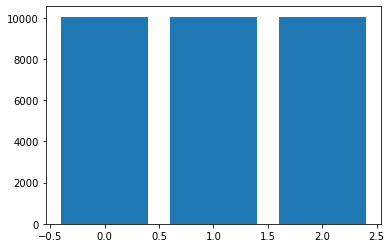

Wall time: 4.29 s


In [140]:
%%time
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot

n_class_sample=10056

strategy = {0:n_class_sample, 1:n_class_sample, 2:n_class_sample}


#strategy = {0:n_class_sample, 1:n_class_sample, 2:n_class_sample, 3:n_class_sample, 4:n_class_sample, 5:n_class_sample,
#            6:n_class_sample, 7:n_class_sample, 8:n_class_sample}
           
oversample = SMOTE(sampling_strategy=strategy,k_neighbors=1)
X_train, y_train = oversample.fit_resample(X_train, y_train)

# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
	per = v / len(y_train) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [141]:
print(X_train.shape)
print(X_valid.shape)

##(45000, 189)
##(1992, 189)

(30168, 189)
(2181, 189)


##### H2O Model on SMOTE data

In [142]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
import h2o
from h2o.automl import H2OAutoML
h2o.init()

X_train_f['target'] = y_train
X_valid_f['target'] = y_valid

X_train_h20 = h2o.H2OFrame(X_train_f)
X_valid_h20 = h2o.H2OFrame(X_valid_f)

# Identify predictors and response
x = list(features)
y = "target"

X_train_h20[y] = X_train_h20[y].asfactor()
X_valid_h20[y] = X_valid_h20[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml_smte = H2OAutoML(max_models=15, seed=123, stopping_metric = 'misclassification')
aml_smte.train(x=x, y=y, training_frame=X_train_h20, validation_frame=X_valid_h20)

preds = aml_smte.leader.predict(X_valid_h20)

pred_h20_valid = h2o.as_list(preds['predict']).predict.values

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
matrix = confusion_matrix(y_valid,pred_h20_valid)
print('Confusion matrix : \n',matrix)

report = classification_report(y_valid,pred_h20_valid)

p2_prediction_wt = pd.read_csv('phase2_prediction_lgb_wt.csv') 
p2_prediction_wt.head()

X_score1 = h2o.H2OFrame(test_f)
preds_h20 = aml_smte.leader.predict(X_score1)

p2_prediction_wt['class_pred_h2o_p2_smote'] = h2o.as_list(preds_h20['predict']).predict.values
p2_prediction_wt['h2o_class_p2_smote'] = p2_prediction_wt['class_pred_h2o_p2_smote'].apply(lambda x:class_decoding[x])
Counter(p2_prediction_wt.h2o_class_p2_smote)

p2_prediction_wt.to_csv("phase2_prediction_h20_smote.csv", index=False)